In [1]:
!ls /mnt/workspace/ucchristus_sample/tmp/

DICOMS	REPORTS


In [2]:
from medvqa.utils.files import read_txt
from medvqa.utils.logging import print_bold
from PIL import Image
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [9]:
def get_dicom_date(dicom_path):
    """Extracts the earliest available date from a DICOM file."""
    try:
        dicom_data = pydicom.dcmread(dicom_path, stop_before_pixels=True)
        
        # Prioritize study date, but fall back to other dates if unavailable
        date_tags = ["StudyDate", "SeriesDate", "AcquisitionDate", "ContentDate"]
        for tag in date_tags:
            dicom_date = dicom_data.get(tag, None)
            if dicom_date:
                return datetime.strptime(dicom_date, "%Y%m%d")
    except Exception as e:
        print(f"Warning: Could not read {dicom_path}: {e}")
    
    return None

def find_dicom_files(folder):
    """Recursively finds all DICOM files in a folder."""
    dicom_files = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(".dcm"):
                dicom_files.append(os.path.join(root, file))
    return dicom_files

def find_txt_files(folder):
    """Recursively finds all TXT files in a folder."""
    txt_files = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(".txt"):
                txt_files.append(os.path.join(root, file))
    return txt_files

def sort_dicom_by_date(folder, verbose=False, return_files=True):
    """Finds all DICOM files in a folder, extracts dates, and prints sorted file paths."""
    dicom_files = find_dicom_files(folder)
    
    # Extract dates and filter out files without valid dates
    dated_files = [(f, get_dicom_date(f)) for f in dicom_files]
    dated_files = [(f, d) for f, d in dated_files if d is not None]
    
    # Sort by date
    sorted_files = sorted(dated_files, key=lambda x: x[1])
    
    # Print sorted file paths
    if verbose:
        for file_path, date in sorted_files:
            print_bold(f"{date.strftime('%Y-%m-%d')}:", end=' '); print(file_path)
    
    if return_files:
        return [f for f, _ in sorted_files]
            
def read_dicom(dicom_file, voi_lut=True, fix_monochrome=True):
    dcm_data = pydicom.read_file(dicom_file)

    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dcm_data.pixel_array, dcm_data)
    else:
        data = dcm_data.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dcm_data.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    # Create a PIL image object
    im = Image.fromarray(data)
    
    return im

In [5]:
def show_study(patient_id, study_id, dir_path='/mnt/workspace/ucchristus_sample/tmp'):
    
    report_path = f"{dir_path}/REPORTS/id_{patient_id}/study-{study_id}/report-{study_id}.txt"
    report_text = read_txt(report_path)    
    
    study_folder = f"{dir_path}/DICOMS/id_{patient_id}/Study_{study_id[:35]}/"
    dicom_files = find_dicom_files(study_folder)
    assert len(dicom_files) > 0
    
    for dicom_file in dicom_files:        
        print_bold('DicomPath:', end=' ')        
        print(dicom_file)

        # Print some metadata
        dicom_data = pydicom.dcmread(dicom_file, stop_before_pixels=True)
        print_bold('StudyInstanceUID:', end=' ')
        print(dicom_data.StudyInstanceUID)
        print_bold('SeriesInstanceUID:', end=' ')
        print(dicom_data.SeriesInstanceUID)
        print_bold('PatientID:', end=' ')
        print(dicom_data.PatientID)
        print_bold('PatientSex:', end=' ')
        print(dicom_data.PatientSex)
        print_bold('PatientAge:', end=' ')
        print(dicom_data.PatientAge)
        print_bold('StudyDate:', end=' ')
        print(datetime.strptime(dicom_data.StudyDate, "%Y%m%d").strftime("%Y-%m-%d"))
        print_bold('Modality:', end=' ')
        print(dicom_data.Modality)
        print_bold('Manufacturer:', end=' ')
        print(dicom_data.Manufacturer)
        print_bold('ManufacturerModelName:', end=' ')
        print(dicom_data.ManufacturerModelName)
        print_bold('BodyPartExamined:', end=' ')
        print(dicom_data.BodyPartExamined)
        print_bold('ViewPosition:', end=' ')
        print(dicom_data.ViewPosition)
        
        # Show the image
        im = read_dicom(dicom_file)
        plt.figure(figsize=(8, 8))  # Reduce the figure size
        plt.imshow(im, cmap="gray")
        plt.axis("off")
        plt.show()
        
    print()
    print_bold('Report:')
    print(report_text)

# Example 1

In [33]:
!ls /mnt/workspace/ucchristus_sample/tmp/REPORTS/id_0221b39336719d5461061415aac6159132b01299/

study-2.25.11514243533111419413312361414125814103432551260615
study-2.25.12101091444310139100391511050811010135528521448109
study-2.25.13011510141410513632122473141267038151231191307075
study-2.25.13710941409123312714147691183440938141013110412115
study-2.25.14293111512501495213111069151291291160136900921327
study-2.25.15081213301929601213181071212151091213145744714138
study-2.25.16810103988915614514121413154011510111012101598911
study-2.25.21312913911861315104149615151372107712364898415751
study-2.25.31191073149101365410101010151251511111213151351537
study-2.25.31214101014113140613141110107810714081157157491121
study-2.25.49601014281311510610312810157113158864685121315121
study-2.25.55216642158145181041109162013563841314121310714514


In [52]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0221b39336719d5461061415aac6159132b01299/', verbose=True, return_files=False)

2018-05-03: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0221b39336719d5461061415aac6159132b01299/Study_2.25.168101039889156145141214131540/Series_2.25.144713583312821429759511397512/image-2.25.680561381215813412635021362106.dcm
2018-05-04: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0221b39336719d5461061415aac6159132b01299/Study_2.25.121010914443101391003915110508/Series_2.25.111111474158158121114915615610/image-2.25.412347621312746313111570146146.dcm
2018-05-07: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0221b39336719d5461061415aac6159132b01299/Study_2.25.130115101414105136321224731412/Series_2.25.573136238412871271551110151014/image-2.25.115110410158540115942365165614.dcm
2018-05-09: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0221b39336719d5461061415aac6159132b01299/Study_2.25.150812133019296012131810712121/Series_2.25.929171181547121510815590681541/image-2.25.111310510137731238144145210133.dcm
2018-05-17: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0221b39336719d546

### Previous study (2018-05-30)

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0221b39336719d5461061415aac6159132b01299/Study_2.25.115142435331114194133123614141/Series_2.25.241341520131112021310118815428/image-2.25.660056116651314971011131213413.dcm
StudyInstanceUID: 2.25.115142435331114194133123614141
SeriesInstanceUID: 2.25.241341520131112021310118815428
PatientID: 0221b39336719d5461061415aac6159132b01299
PatientSex: M
PatientAge: 062Y
StudyDate: 2018-05-30
Modality: DX
Manufacturer: 0fa5e7a5d523b25b6d8fd91c3b1d2059
ManufacturerModelName: ac560d1a4308f6dd82b45195f223482f
BodyPartExamined: CHEST
ViewPosition: AP


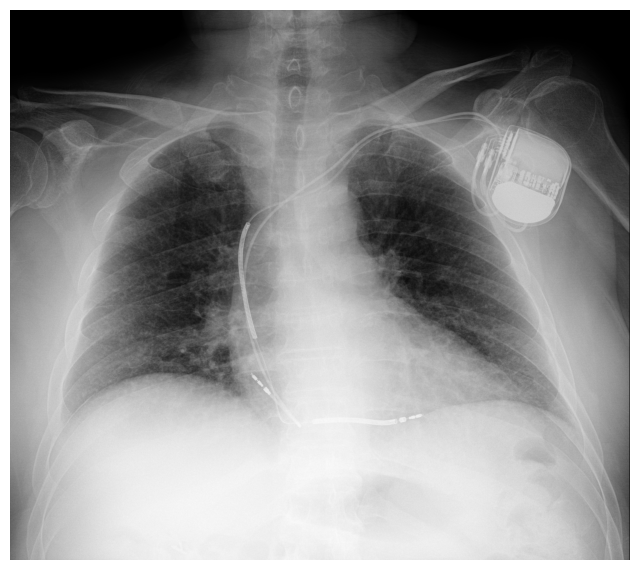

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0221b39336719d5461061415aac6159132b01299/Study_2.25.115142435331114194133123614141/Series_2.25.241341520131112021310118815428/image-2.25.120144711814111431005001011014.dcm
StudyInstanceUID: 2.25.115142435331114194133123614141
SeriesInstanceUID: 2.25.241341520131112021310118815428
PatientID: 0221b39336719d5461061415aac6159132b01299
PatientSex: M
PatientAge: 062Y
StudyDate: 2018-05-30
Modality: DX
Manufacturer: 0fa5e7a5d523b25b6d8fd91c3b1d2059
ManufacturerModelName: ac560d1a4308f6dd82b45195f223482f
BodyPartExamined: CHEST
ViewPosition: LL


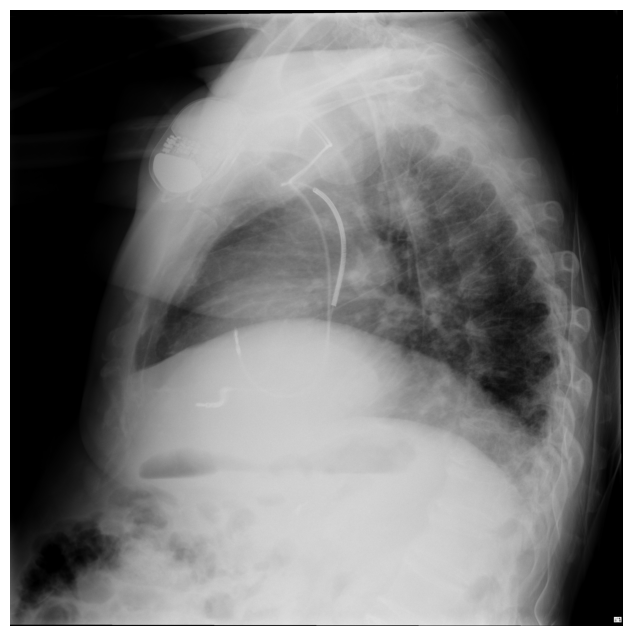


Report:
RADIOGRAFÍA DE TÓRAX PA - LATERAL 
Caja de marcapasos bicameral resincronizador - desfibrilador sobreproyectada a la región pectoral 
izquierda, conectada a electrodos subclavios ipsilaterales con extremos distales en aurícula y 
ventrículo derechos. 
Volúmenes pulmonares conservados. 
Diafragma bien delimitado. 
No se observan focos de condensación en el parénquima pulmonar. 
No hay signos de edema intersticial. 
Leve aumento de tamaño de la silueta cardíaca. 
Aorta torácica levemente elongada. 
Hilios y dibujo vascular pulmonar sin alteraciones. 



In [56]:
show_study(patient_id='0221b39336719d5461061415aac6159132b01299',
           study_id='2.25.11514243533111419413312361414125814103432551260615')

### Current study (2018-06-09)

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0221b39336719d5461061415aac6159132b01299/Study_2.25.213129139118613151041496151513/Series_2.25.148774103391451261111539409121/image-2.25.122159121140131204301201561114.dcm
StudyInstanceUID: 2.25.213129139118613151041496151513
SeriesInstanceUID: 2.25.148774103391451261111539409121
PatientID: 0221b39336719d5461061415aac6159132b01299
PatientSex: M
PatientAge: 062Y
StudyDate: 2018-06-09
Modality: DX
Manufacturer: 0fa5e7a5d523b25b6d8fd91c3b1d2059
ManufacturerModelName: a0089df4ee610cfaf0a8ebd168d0e24a
BodyPartExamined: CHEST
ViewPosition: AP


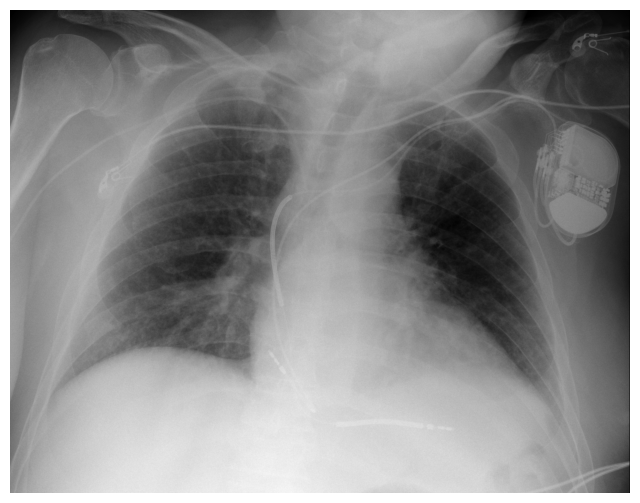


Report:
RADIOGRAFÍA DE TÓRAX AP PORTÁTIL 
En comparación a estudio de hace 5 días se ha retirado catéter venoso central subclavio derecho y 
se ha instalado catéter venoso de inserción periférica de trayecto subclavio derecho con extremo 
distal insinuado en vena cava superior. 
Diafragma de contornos bien definidos. 
No hay signos categóricos de derrame pleural ni neumotórax. 
Tórax corto por inspiración poco profunda. 
No se observan focos de relleno alveolar en el parénquima pulmonar. 
No hay signos de edema intersticial. 
Leve aumento de tamaño de la silueta cardíaca. 
Aorta torácica levemente elongada. 
Hilios y dibujo vascular pulmonar sin alteraciones. 
Caja de marcapasos - desfibrilador sobreproyectada a la región pectoral izquierda con electrodos 
que ingresan vía subclavia ipsilateral con extremos distales en cavidades cardíacas derechas. 



In [57]:
show_study(patient_id='0221b39336719d5461061415aac6159132b01299',
           study_id='2.25.21312913911861315104149615151372107712364898415751')

### Facts extracted from report

- The right subclavian central venous catheter previously observed has been removed.
- A peripherally inserted venous catheter has been placed through the right subclavian route.
- The distal tip of the peripherally inserted venous catheter is suggested to be located in the superior vena cava.
- The diaphragm contours are well-defined.
- No signs of pleural effusion are observed.
- No signs of pneumothorax are observed.
- The thorax appears short due to shallow inspiration.
- No alveolar filling foci are observed in the pulmonary parenchyma.
- No signs of interstitial edema are observed.
- There is mild enlargement of the cardiac silhouette.
- The thoracic aorta is slightly elongated.
- The pulmonary hila show no alterations.
- The pulmonary vascular markings show no alterations.
- A pacemaker-defibrillator box is superimposed on the left pectoral region.
- Electrodes from the pacemaker-defibrillator enter via the left subclavian route.
- The distal tips of the pacemaker-defibrillator electrodes are located in the right cardiac chambers.

# Example 2

In [53]:
!ls /mnt/workspace/ucchristus_sample/tmp/REPORTS/id_5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7/

study-2.25.10914891012413312121120669914081151300151224312913
study-2.25.11131015138769413521111530713111305714151409108363
study-2.25.11312121211571112961331270781313511131211363152109
study-2.25.11321501161011513143157132912811110159012149131314
study-2.25.12131035880480106233412915152315778121589112913141
study-2.25.12483113708923122080118564214339101261215051413128
study-2.25.15251511534690101530464501100531017421571575115411
study-2.25.20210131538153511713687815542117131104155133915713
study-2.25.25061114691084415361013191003415127571369932140310
study-2.25.37281010114155315111412313985115152122142813157514
study-2.25.50108856289131311411421371515261010211126141105715
study-2.25.53871191515714805121061485647141261312127511514051
study-2.25.61261351581911813410011101121071198236842140621401
study-2.25.61466125171564135154869156212012669414326652811499
study-2.25.69745111012138291521115421513153142211105341248141


In [54]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp/DICOMS/id_5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7/', verbose=True, return_files=False)

2017-12-31: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7/Study_2.25.113215011610115131431571329128/Series_2.25.711213101014111431114156215911/image-2.25.912153491014125514131313101504.dcm
2018-01-05: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7/Study_2.25.614661251715641351548691562120/Series_2.25.128015215144012274413914138143/image-2.25.155233141521511218111391115951.dcm
2018-01-09: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7/Study_2.25.113121212115711129613312707813/Series_2.25.406301214147151471206510115510/image-2.25.919210101001014998215111412413.dcm
2018-01-12: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7/Study_2.25.614661251715641351548691562120/Series_2.25.128015215144012274413914138143/image-2.25.180148014791501085122119527071.dcm
2018-01-20: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_5c6fdc9f48f5fa7cb

### Previous study (2018-03-09 (frontal), 2018-03-12 (lateral))

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7/Study_2.25.612613515819118134100111011210/Series_2.25.212612114249102615661496121531/image-2.25.143125314200015101454175128515.dcm
StudyInstanceUID: 2.25.612613515819118134100111011210
SeriesInstanceUID: 2.25.212612114249102615661496121531
PatientID: 5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7
PatientSex: M
PatientAge: 050Y
StudyDate: 2018-03-09
Modality: DX
Manufacturer: 0fa5e7a5d523b25b6d8fd91c3b1d2059
ManufacturerModelName: ac560d1a4308f6dd82b45195f223482f
BodyPartExamined: CHEST
ViewPosition: PA


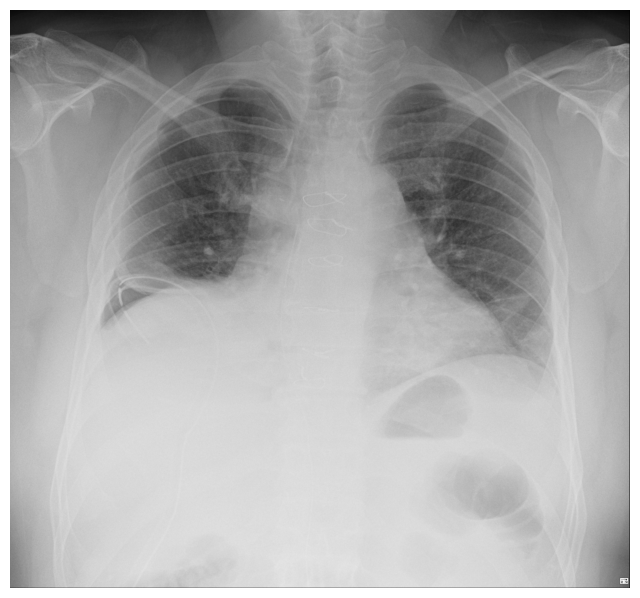

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7/Study_2.25.612613515819118134100111011210/Series_2.25.212612114249102615661496121531/image-2.25.657121451118121314560101598879.dcm
StudyInstanceUID: 2.25.612613515819118134100111011210
SeriesInstanceUID: 2.25.212612114249102615661496121531
PatientID: 5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7
PatientSex: M
PatientAge: 050Y
StudyDate: 2018-03-12
Modality: DX
Manufacturer: 0fa5e7a5d523b25b6d8fd91c3b1d2059
ManufacturerModelName: ac560d1a4308f6dd82b45195f223482f
BodyPartExamined: CHEST
ViewPosition: LL


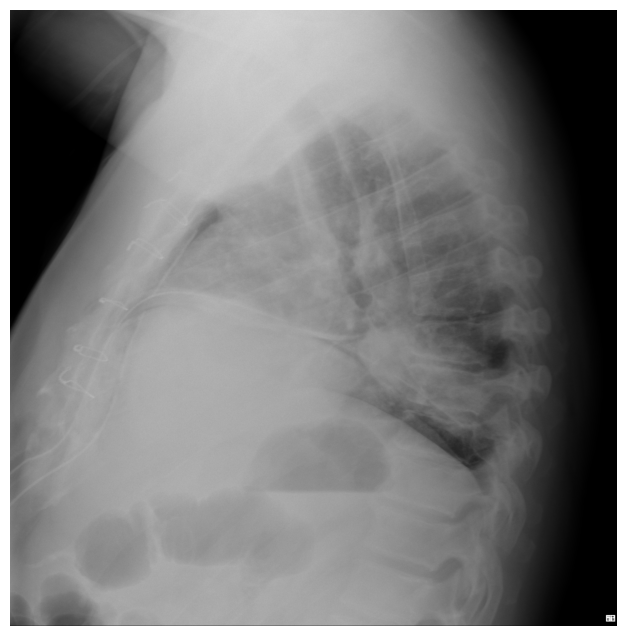


Report:
RADIOGRAFÍA DE TÓRAX POSTEROANTERIOR Y LATERAL 
Se dispone para comparar de serie de estudios previos; el más reciente,  radiografía de tórax 
En comparación el estudio referencia, se ha hecho evidente leve neumotórax derecho. Leve 
derrame pleural derecho. 
No hay signos categóricos de derrame pleural ni neumotórax izquierdos. 
Tubo de drenaje pleural derecho y tubo de drenaje mediastínico sin cambios en su posición. 
Cambios postquirúrgicos de esternotomía media, con suturas esternales metálicas bien alineadas e 
íntegras. 
Opacidad de aspecto atelectásico basal derecha. No se han hecho evidentes nuevas opacidades 
parenquimatosas. No hay signos categóricos de edema intersticial. 
Silueta cardiomediastínica sin cambios. 
Resto del estudio sin variaciones.  



In [60]:
show_study(patient_id='5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7',
           study_id='2.25.61261351581911813410011101121071198236842140621401')

### Current study (2018-03-11 (lateral), 2018-03-19 (frontal))

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7/Study_2.25.124831137089231220801185642143/Series_2.25.860037283912948541121412181137/image-2.25.121415359418011511113105111413.dcm
StudyInstanceUID: 2.25.124831137089231220801185642143
SeriesInstanceUID: 2.25.860037283912948541121412181137
PatientID: 5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7
PatientSex: M
PatientAge: 050Y
StudyDate: 2018-03-11
Modality: CR
Manufacturer: b6f53126cf1571d26815324e6968f3d9
ManufacturerModelName: c58c8821c8f9c56d0b07ecdde6e929fb
BodyPartExamined: CHEST
ViewPosition: PA


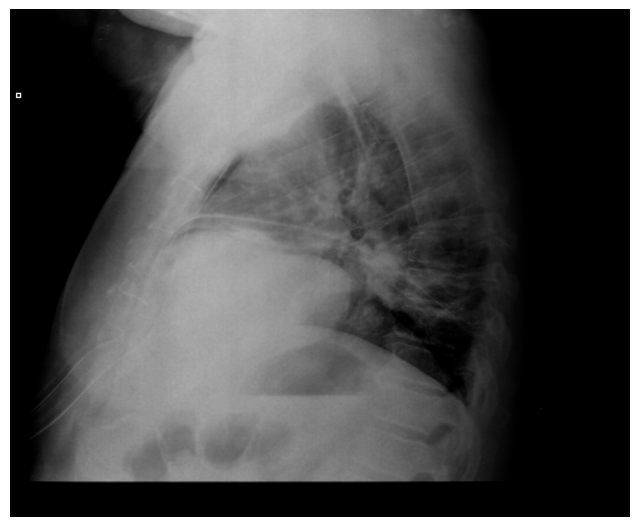

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7/Study_2.25.124831137089231220801185642143/Series_2.25.191512101168784127141291311147/image-2.25.108851413268142158584741310622.dcm
StudyInstanceUID: 2.25.124831137089231220801185642143
SeriesInstanceUID: 2.25.191512101168784127141291311147
PatientID: 5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7
PatientSex: M
PatientAge: 050Y
StudyDate: 2018-03-19
Modality: CR
Manufacturer: b6f53126cf1571d26815324e6968f3d9
ManufacturerModelName: c58c8821c8f9c56d0b07ecdde6e929fb
BodyPartExamined: CHEST
ViewPosition: PA


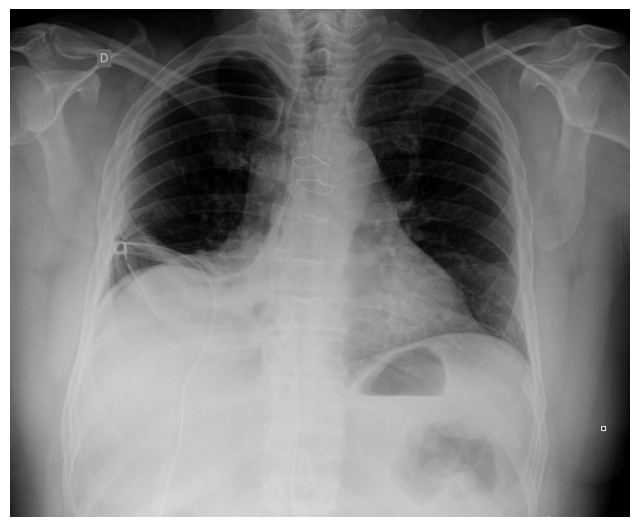


Report:
RADIOGRAFÍA DE TÓRAX PA - LATERAL 
volumen relativo del hemitórax derecho, sin cambios. 
Persiste leve neumotórax derecho. No hay signos de neumotórax izquierdo ni de derrame pleural. 
Discreto neumomediastino. 
Cambios postquirúrgicos de resección de tumor mediastínico anterior, con suturas metálicas de 
esternotomía media, bien alineadas e íntegras. 
Persisten dos tubos de drenaje pleural derecho, uno sobroproyectado a la región basal posterior y 
otro a la región anterior. 
No hay focos de condensación de aspecto neumónico en el parénquima pulmonar. 
Opacidades parenquimatosas en el lóbulo inferior derecho de aspecto atelectásico. 
Silueta cardiomediastínica sin cambios. 
Hilios y dibujo vascular pulmonar sin alteraciones. 



In [58]:
show_study(patient_id='5c6fdc9f48f5fa7cb54275883e0910bedc9e4eb7',
           study_id='2.25.12483113708923122080118564214339101261215051413128')

### Facts extracted from report

- The relative volume of the right hemithorax is unchanged.
- There is a mild right pneumothorax.
- No signs of left pneumothorax are observed.
- No signs of pleural effusion are observed.
- There is mild pneumomediastinum.
- There are postsurgical changes from anterior mediastinal tumor resection.
- Metallic sutures from median sternotomy are present, well-aligned and intact.
- Two right pleural drainage tubes are present.
- One drainage tube is superimposed on the posterior basal region.
- One drainage tube is superimposed on the anterior region.
- No pneumonic-appearing consolidations are observed in the pulmonary parenchyma.
- There are parenchymal opacities in the right lower lobe consistent with atelectasis.
- The cardiomediastinal silhouette is unchanged.
- The pulmonary hila are normal.
- The pulmonary vascular markings are normal.

# Example 3

In [61]:
!ls /mnt/workspace/ucchristus_sample/tmp/REPORTS/id_0cbfbcaaa8ff8d57d62746888229c8c491f5bfe3/

study-2.25.10111212111323131471532609501161154730111113615154
study-2.25.11051501014585342019701213211210761331761221490151
study-2.25.11108515129700381393411301310142111121431132914151
study-2.25.11119012198150065914213481118710158534713167121311
study-2.25.11314158466810360512075121430554814104810102814131
study-2.25.11436657131220715151151129110015785691111461070812
study-2.25.12001110112010116112713725134811131227489570103110
study-2.25.13111152131061091014115952212114148210910614121112
study-2.25.13155210897145810113839978393134144115913101031487
study-2.25.13315113111311711711112515103131415128102130136410
study-2.25.14151462111215310815561581271114811110891510991114
study-2.25.16101037101014939153310611171321061121127341099611
study-2.25.18013251100125154156631110131512396212021001144369
study-2.25.18312632111015125910314113012071394561180030102912
study-2.25.36881149015862613913404521284134312151311111006132
study-2.25.41111714912141561411436413834630193117893130131561
study-2.

In [62]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0cbfbcaaa8ff8d57d62746888229c8c491f5bfe3/', verbose=True, return_files=False)

2018-01-07: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0cbfbcaaa8ff8d57d62746888229c8c491f5bfe3/Study_2.25.161010371010149391533106111713/Series_2.25.151113108081313157044809171011/image-2.25.512112163904651415105813136561.dcm
2018-01-12: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0cbfbcaaa8ff8d57d62746888229c8c491f5bfe3/Study_2.25.161010371010149391533106111713/Series_2.25.802651214113720371541131071223/image-2.25.422129121371211121417819141541.dcm
2019-08-04: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0cbfbcaaa8ff8d57d62746888229c8c491f5bfe3/Study_2.25.910371352147593130111415121321/Series_2.25.310151510915311331214119119612/image-2.25.141511121391533145868039012141.dcm
2019-08-10: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0cbfbcaaa8ff8d57d62746888229c8c491f5bfe3/Study_2.25.910371352147593130111415121321/Series_2.25.667114451511615111591391516111/image-2.25.981181415141445067122053811715.dcm
2020-07-30: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0cbfbcaaa8ff8d57d

### Current study (2018-01-07 (lateral), 2018-01-12 (frontal))

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0cbfbcaaa8ff8d57d62746888229c8c491f5bfe3/Study_2.25.161010371010149391533106111713/Series_2.25.151113108081313157044809171011/image-2.25.512112163904651415105813136561.dcm
StudyInstanceUID: 2.25.161010371010149391533106111713
SeriesInstanceUID: 2.25.151113108081313157044809171011
PatientID: 0cbfbcaaa8ff8d57d62746888229c8c491f5bfe3
PatientSex: F
PatientAge: 078Y
StudyDate: 2018-01-07
Modality: CR
Manufacturer: b6f53126cf1571d26815324e6968f3d9
ManufacturerModelName: c58c8821c8f9c56d0b07ecdde6e929fb
BodyPartExamined: CHEST
ViewPosition: PA


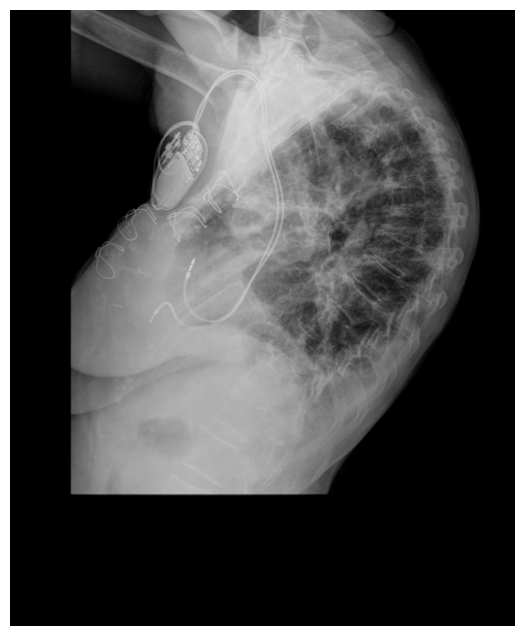

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_0cbfbcaaa8ff8d57d62746888229c8c491f5bfe3/Study_2.25.161010371010149391533106111713/Series_2.25.802651214113720371541131071223/image-2.25.422129121371211121417819141541.dcm
StudyInstanceUID: 2.25.161010371010149391533106111713
SeriesInstanceUID: 2.25.802651214113720371541131071223
PatientID: 0cbfbcaaa8ff8d57d62746888229c8c491f5bfe3
PatientSex: F
PatientAge: 078Y
StudyDate: 2018-01-12
Modality: CR
Manufacturer: b6f53126cf1571d26815324e6968f3d9
ManufacturerModelName: c58c8821c8f9c56d0b07ecdde6e929fb
BodyPartExamined: CHEST
ViewPosition: PA


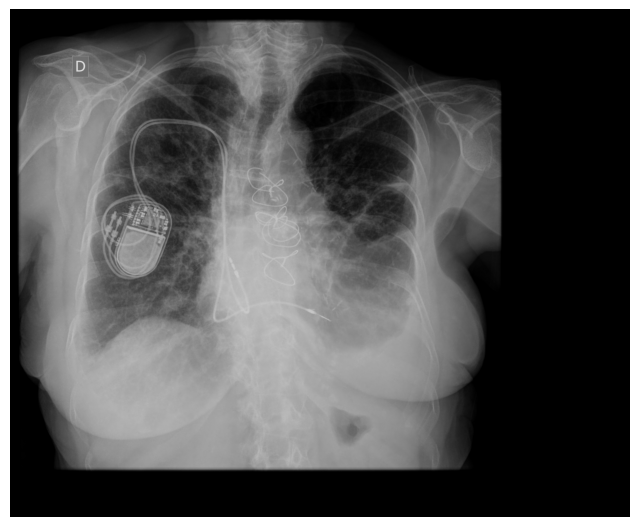


Report:
RADIOGRAFÍA DE TÓRAX PA - LATERAL 
Tórax corto por inspiración poco profunda. 
Caja marcapasos sobreproyectada la región pectoral derecha conectada electrodos que ingresan 
vía vena subclavia ipsilateral con extremos distales en cavidades cardíacas derechas. 
Cambios postquirúrgicos de cirugía de revascularización miocárdica, con suturas esternales 
metálicas fracturadas en línea media y clips quirúrgicos sobreproyectados al mediastino. 
Leve derrame pleural bilateral mayor a izquierda. No hay signos de neumotórax. 
No se observan focos de condensación de tipo neumónico ni masas en el parénquima pulmonar. 
Engrosamiento del intersticio peribroncovascular de predominio central en forma bilateral, 
sugerentes de edema intersticial. Atelectasias subsegmentarias en ambas bases pulmonares. 
Leve aumento de tamaño de la silueta cardíaca. 
Aorta torácica elongada con placas de ateroma cálcico en su cayado. 
Hilios y dibujo vascular pulmonar sin alteraciones. 



In [10]:
show_study(patient_id='0cbfbcaaa8ff8d57d62746888229c8c491f5bfe3',
           study_id='2.25.16101037101014939153310611171321061121127341099611')

### Facts extracted from report

- The thorax appears shortened due to shallow inspiration.
- A pacemaker box is superimposed on the right pectoral region.
- Electrodes from the pacemaker enter through the right subclavian vein.
- The distal ends of the pacemaker electrodes are located in the right cardiac chambers.
- Postsurgical changes from myocardial revascularization surgery are observed.
- Fractured metallic sternal sutures are present in the midline.
- Surgical clips are superimposed on the mediastinum.
- Mild bilateral pleural effusion is present.
- The pleural effusion is greater on the left side.
- No signs of pneumothorax are observed.
- No pneumonic-type consolidation foci are observed in the pulmonary parenchyma.
- No masses are observed in the pulmonary parenchyma.
- Bilateral thickening of the peribronchovascular interstitium predominantly central is observed.
- The thickening is suggestive of interstitial edema.
- Subsegmental atelectasis is present in both pulmonary bases.
- Mild enlargement of the cardiac silhouette is observed.
- The thoracic aorta is elongated.
- Calcified atheromatous plaques are present in the aortic arch.
- The pulmonary hila show no abnormalities.
- The pulmonary vascular markings show no abnormalities.

# Example 4

In [64]:
!ls /mnt/workspace/ucchristus_sample/tmp/REPORTS/id_01713b3b6548bae0f8932d5baf83e5479a0f6cd0/

study-2.25.18712141311415089351331231130551212111111815114671
study-2.25.21415492172141010518121110791215291213010151575051
study-2.25.41227064951241158155131381412075691271113134134134
study-2.25.71441151615213141253113014158481191512670215800109


In [65]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp/DICOMS/id_01713b3b6548bae0f8932d5baf83e5479a0f6cd0/', verbose=True, return_files=False)

2018-08-13: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_01713b3b6548bae0f8932d5baf83e5479a0f6cd0/Study_2.25.714411516152131412531130141584/Series_2.25.210210678713814193610140733401/image-2.25.705421346014155121331410941551.dcm
2021-10-01: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_01713b3b6548bae0f8932d5baf83e5479a0f6cd0/Study_2.25.187121413114150893513312311305/Series_2.25.101464813141128015511214210415/image-2.25.821311141110026810851813111212.dcm
2021-10-06: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_01713b3b6548bae0f8932d5baf83e5479a0f6cd0/Study_2.25.187121413114150893513312311305/Series_2.25.159510749127715301201012151311/image-2.25.210114143111212140150455951365.dcm
2022-10-29: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_01713b3b6548bae0f8932d5baf83e5479a0f6cd0/Study_2.25.412270649512411581551313814120/Series_2.25.515201312150138813782554134127/image-2.25.137150141241214127691311189610.dcm
2022-11-02: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_01713b3b6548bae0f

### Current study (2021-10-06 (frontal), 2021-10-01 (lateral))

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_01713b3b6548bae0f8932d5baf83e5479a0f6cd0/Study_2.25.187121413114150893513312311305/Series_2.25.159510749127715301201012151311/image-2.25.210114143111212140150455951365.dcm
StudyInstanceUID: 2.25.187121413114150893513312311305
SeriesInstanceUID: 2.25.159510749127715301201012151311
PatientID: 01713b3b6548bae0f8932d5baf83e5479a0f6cd0
PatientSex: F
PatientAge: 057Y
StudyDate: 2021-10-06
Modality: CR
Manufacturer: b6f53126cf1571d26815324e6968f3d9
ManufacturerModelName: a588b8d234233a4af86728cd4bd1c542
BodyPartExamined: CHEST
ViewPosition: PA


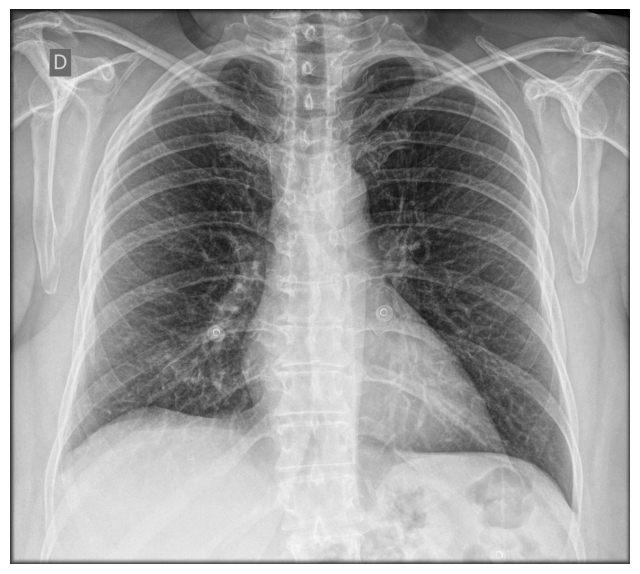

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_01713b3b6548bae0f8932d5baf83e5479a0f6cd0/Study_2.25.187121413114150893513312311305/Series_2.25.101464813141128015511214210415/image-2.25.821311141110026810851813111212.dcm
StudyInstanceUID: 2.25.187121413114150893513312311305
SeriesInstanceUID: 2.25.101464813141128015511214210415
PatientID: 01713b3b6548bae0f8932d5baf83e5479a0f6cd0
PatientSex: F
PatientAge: 057Y
StudyDate: 2021-10-01
Modality: CR
Manufacturer: b6f53126cf1571d26815324e6968f3d9
ManufacturerModelName: a588b8d234233a4af86728cd4bd1c542
BodyPartExamined: CHEST
ViewPosition: PA


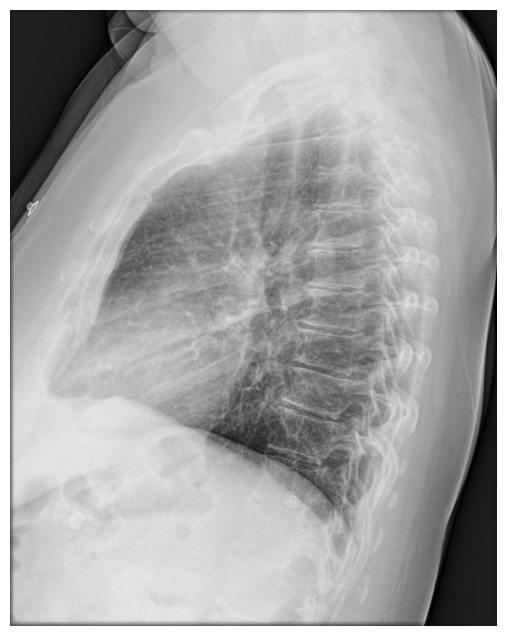


Report:
RADIOGRAFÍA DE TÓRAX PA - LATERAL 
Diafragma bien delimitado. 
No hay signos de derrame pleural ni neumotórax. 
Volúmenes pulmonares normales. 
No se observan focos de condensación ni masas en el parénquima pulmonar.  
Silueta cardíaca de tamaño dentro de límites normales. 
Aorta torácica, hilios y dibujo vascular pulmonar sin alteraciones. 



In [66]:
show_study(patient_id='01713b3b6548bae0f8932d5baf83e5479a0f6cd0',
           study_id='2.25.18712141311415089351331231130551212111111815114671')

### Facts extracted from report

- The diaphragm is well-defined.
- No signs of pleural effusion are observed.
- No signs of pneumothorax are observed.
- Pulmonary volumes are normal.
- No consolidation foci are observed in the pulmonary parenchyma.
- No masses are observed in the pulmonary parenchyma.
- The cardiac silhouette size is within normal limits.
- The thoracic aorta shows no abnormalities.
- The pulmonary hila show no abnormalities.
- The pulmonary vascular markings show no abnormalities.

# Example 5

In [67]:
!ls /mnt/workspace/ucchristus_sample/tmp/REPORTS/id_2210e45d77168290ed16ca810465eebab9a2b293/

study-2.25.12058110345116180697131313101143181438021013615761
study-2.25.21411701481111514121331966411061415715771087814565
study-2.25.65122315131311510612041094411151007573610121231421
study-2.25.81112138231281387145013114111254771585121101900059


In [68]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp/DICOMS/id_2210e45d77168290ed16ca810465eebab9a2b293/', verbose=True, return_files=False)

2023-08-05: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_2210e45d77168290ed16ca810465eebab9a2b293/Study_2.25.811121382312813871450131141112/Series_2.25.112153485123121314104103154811/image-2.25.101111012121313122869431129184.dcm
2023-08-14: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_2210e45d77168290ed16ca810465eebab9a2b293/Study_2.25.811121382312813871450131141112/Series_2.25.151012156102106643144151512111/image-2.25.141011451030612601301464654113.dcm
2023-08-24: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_2210e45d77168290ed16ca810465eebab9a2b293/Study_2.25.214117014811115141213319664110/Series_2.25.141157325561113765215237148149/image-2.25.117124102115123813445772911322.dcm
2023-08-24: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_2210e45d77168290ed16ca810465eebab9a2b293/Study_2.25.214117014811115141213319664110/Series_2.25.126038113274511913511129131581/image-2.25.101159158128268151313146115800.dcm
2023-09-03: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_2210e45d77168290e

### Current study (2023-09-08 (lateral), 2023-09-03 (frontal))

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_2210e45d77168290ed16ca810465eebab9a2b293/Study_2.25.120581103451161806971313131011/Series_2.25.351329320441414915911191014711/image-2.25.126812861415121213123131191215.dcm
StudyInstanceUID: 2.25.120581103451161806971313131011
SeriesInstanceUID: 2.25.351329320441414915911191014711
PatientID: 2210e45d77168290ed16ca810465eebab9a2b293
PatientSex: F
PatientAge: 036Y
StudyDate: 2023-09-08
Modality: CR
Manufacturer: 0fa5e7a5d523b25b6d8fd91c3b1d2059
ManufacturerModelName: ac560d1a4308f6dd82b45195f223482f
BodyPartExamined: CHEST
ViewPosition: 


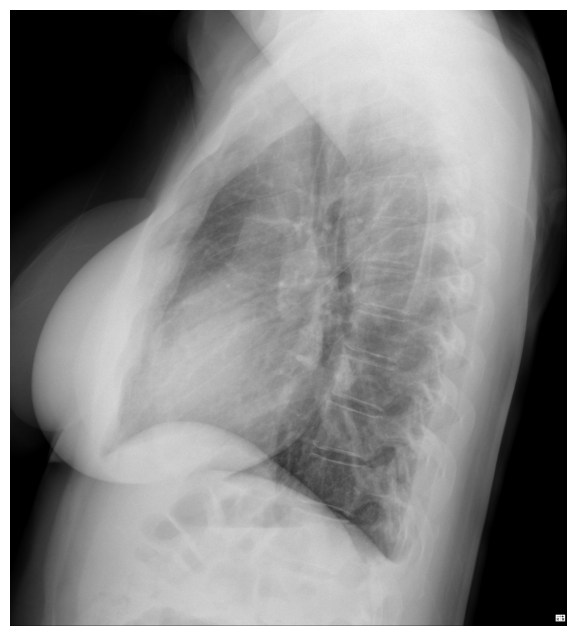

DicomPath: /mnt/workspace/ucchristus_sample/tmp/DICOMS/id_2210e45d77168290ed16ca810465eebab9a2b293/Study_2.25.120581103451161806971313131011/Series_2.25.102151411113115751315111015101/image-2.25.710310101410127432888151015110.dcm
StudyInstanceUID: 2.25.120581103451161806971313131011
SeriesInstanceUID: 2.25.102151411113115751315111015101
PatientID: 2210e45d77168290ed16ca810465eebab9a2b293
PatientSex: F
PatientAge: 036Y
StudyDate: 2023-09-03
Modality: CR
Manufacturer: 0fa5e7a5d523b25b6d8fd91c3b1d2059
ManufacturerModelName: ac560d1a4308f6dd82b45195f223482f
BodyPartExamined: CHEST
ViewPosition: 


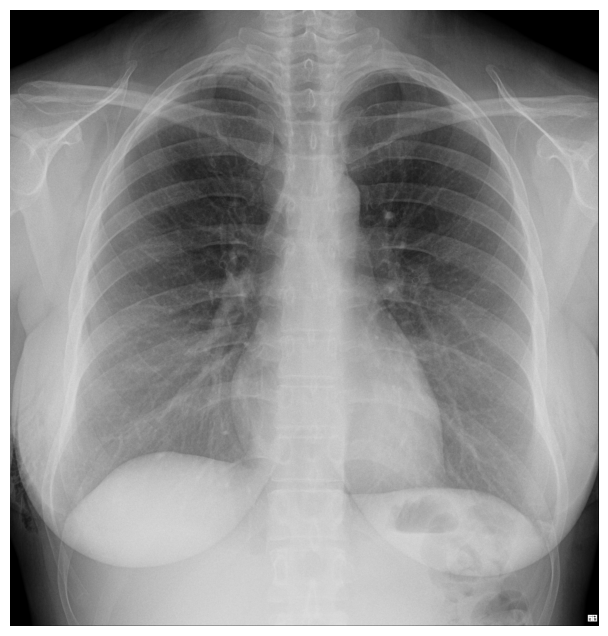


Report:
RADIOGRAFÍA TÓRAX POSTEROANTERIOR Y LATERAL
Postoperatorio de simpatectomía.
Se dispone para comparar de radiografía de ayer.
Leve enfisema subcutáneo en la pared lateral del hemitórax derecho sin cambios significativos.
Diafragma bien delimitado.
No hay signos de derrame pleural ni neumotórax.
No se observan focos de condensación ni masas en el parénquima pulmonar.
Silueta cardíaca de tamaño dentro de límites normales.
Aorta torácica, hilios y dibujo vascular pulmonar sin alteraciones.



In [69]:
show_study(patient_id='2210e45d77168290ed16ca810465eebab9a2b293',
           study_id='2.25.12058110345116180697131313101143181438021013615761')

### Facts extracted from report

- The study includes a posteroanterior chest radiograph view.
- The study includes a lateral chest radiograph view.
- The patient is in postoperative status after sympathectomy.
- A previous radiograph from yesterday is available for comparison.
- Mild subcutaneous emphysema is observed in the lateral wall of the right hemithorax.
- The subcutaneous emphysema shows no significant changes compared to the previous study.
- The diaphragm is well-defined.
- No signs of pleural effusion are observed.
- No signs of pneumothorax are observed.
- No consolidation foci are observed in the pulmonary parenchyma.
- No masses are observed in the pulmonary parenchyma.
- The cardiac silhouette size is within normal limits.
- The thoracic aorta shows no abnormalities.
- The pulmonary hila show no abnormalities.
- The pulmonary vascular markings show no abnormalities.

# Example 6

In [73]:
!ls /mnt/workspace/ucchristus_sample/tmp2/REPORTS/id_2292e38f8196473555edb44c2575bed5aed86ed4/

study-2.25.41084488119251590111224715601228081515121885107010


In [74]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_2292e38f8196473555edb44c2575bed5aed86ed4/', verbose=True, return_files=False)

2020-10-08: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_2292e38f8196473555edb44c2575bed5aed86ed4/Study_2.25.410844881192515901112247156012/Series_2.25.643148286274281117120133541997/image-2.25.501161187106109872124141365139.dcm
2020-10-19: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_2292e38f8196473555edb44c2575bed5aed86ed4/Study_2.25.410844881192515901112247156012/Series_2.25.643148286274281117120133541997/image-2.25.116411312972715916811047297101.dcm


DicomPath: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_2292e38f8196473555edb44c2575bed5aed86ed4/Study_2.25.410844881192515901112247156012/Series_2.25.643148286274281117120133541997/image-2.25.501161187106109872124141365139.dcm
StudyInstanceUID: 2.25.410844881192515901112247156012
SeriesInstanceUID: 2.25.643148286274281117120133541997
PatientID: 2292e38f8196473555edb44c2575bed5aed86ed4
PatientSex: M
PatientAge: 019Y
StudyDate: 2020-10-08
Modality: DX
Manufacturer: 0fa5e7a5d523b25b6d8fd91c3b1d2059
ManufacturerModelName: ac560d1a4308f6dd82b45195f223482f
BodyPartExamined: CHEST
ViewPosition: LL


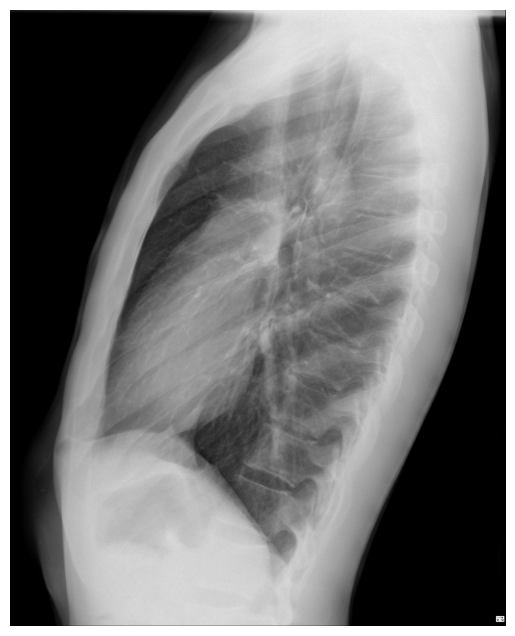

DicomPath: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_2292e38f8196473555edb44c2575bed5aed86ed4/Study_2.25.410844881192515901112247156012/Series_2.25.643148286274281117120133541997/image-2.25.116411312972715916811047297101.dcm
StudyInstanceUID: 2.25.410844881192515901112247156012
SeriesInstanceUID: 2.25.643148286274281117120133541997
PatientID: 2292e38f8196473555edb44c2575bed5aed86ed4
PatientSex: M
PatientAge: 019Y
StudyDate: 2020-10-19
Modality: DX
Manufacturer: 0fa5e7a5d523b25b6d8fd91c3b1d2059
ManufacturerModelName: ac560d1a4308f6dd82b45195f223482f
BodyPartExamined: CHEST
ViewPosition: PA


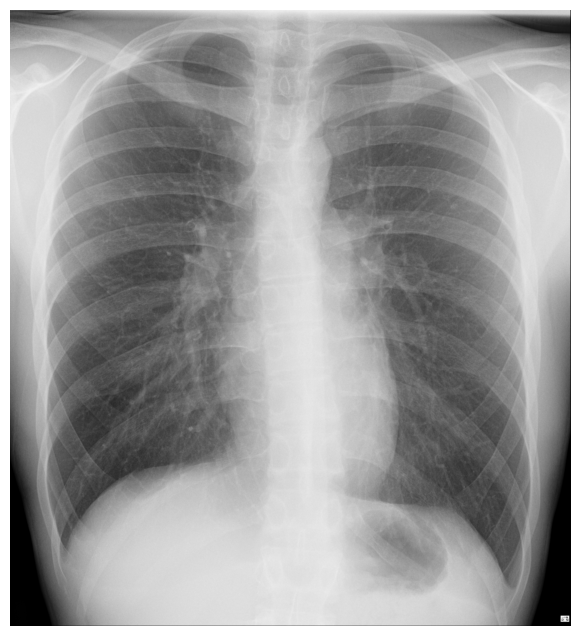


Report:
Radiografía de extremidades inferiores AP en posición de pie en folio graduado. 
Hallazgos. 
Densidad ósea normal. 
No se observa lesión ósea traumática ni destructiva. 
Espacios articulares son amplitud normal y contorno regulares. 
Ángulo anatómico de 0,4° en varo a derecha. 
Ángulo anatómico de 0° a izquierda. 
Ángulo mecánico de 5,6° en varo a derecha. 
Ángulo de 4,7° en varo a izquierda. 
Sin desnivel pelviano significativo. 
No se observan calcificaciones intra ni periarticulares. 
Radiografía de columna total AP- lateral de pie en folio graduado. 
Densidad ósea normal. 
No se observa lesión ósea traumática ni destructiva. 
Presenta siete vértebras cervicales, 12 vertebras dorsales con doce pares de costillas y cinco 
vértebras lumbares. 
Incurvación dorsal de convexidad derecha de 10° con leve rotación de cuerpos vertebrales medido 
desde plataforma superior de T1 a plataforma inferior de T8. Incurvación dorsolumbar de 
convexidad izquierda de 11° desde la plataforma su

In [79]:
show_study(patient_id='2292e38f8196473555edb44c2575bed5aed86ed4',
           study_id='2.25.41084488119251590111224715601228081515121885107010',
           dir_path='/mnt/workspace/ucchristus_sample/tmp2')

### Facts extracted from report

**Radiografía de extremidades inferiores AP en posición de pie en folio graduado.**
- Bone density is normal.
- No traumatic bone lesion is observed.
- No destructive bone lesion is observed.
- Joint spaces have normal amplitude.
- Joint contours are regular.
- The anatomical angle to the right is 0.4° varus.
- The anatomical angle to the left is 0°.
- The mechanical angle to the right is 5.6° varus.
- The angle to the left is 4.7° varus.
- There is no significant pelvic tilt.
- No intra-articular calcifications are observed.
- No periarticular calcifications are observed.

**Radiografía de columna total AP- lateral de pie en folio graduado.**

- Bone density is normal.
- No traumatic bone lesion is observed.
- No destructive bone lesion is observed.
- There are seven cervical vertebrae.
- There are twelve thoracic vertebrae.
- There are twelve pairs of ribs.
- There are five lumbar vertebrae.
- Dorsal curvature with right convexity is 10 degrees.
- Slight rotation of vertebral bodies is present from T1 to T8.
- Dorsolumbar curvature with left convexity is 11 degrees.
- Slight rotation of vertebral bodies is present from T9 to L3.
- No significant pelvic tilt is observed.
- Dorsal kyphosis is 43 degrees.
- Lumbar lordosis is 45 degrees.
- No significant coronal imbalance is observed.
- No significant sagittal imbalance is observed.

**RADIOGRAFÍA DE TÓRAX PA - LATERAL**

- Lung volumes are symmetrical.
- The diaphragm is well-defined.
- No signs of pleural effusion are observed.
- No signs of pneumothorax are observed.
- No foci of pneumonia-like consolidation are observed in the pulmonary parenchyma.
- No masses are observed in the pulmonary parenchyma.
- The cardiac silhouette is of normal size.
- The thoracic aorta is without alterations.
- The hila are without alterations.
- The pulmonary vascular pattern is without alterations.
- The examination reveals no current pathological findings.

**Radiografía de columna cervical en proyección AP y lateral.**

- Bone density is normal.
- No traumatic bone lesion is observed.
- No destructive bone lesion is observed.
- Alignment in the coronal axis is proper.
- Alignment in the sagittal axis is proper.
- Vertebral bodies have normal height.
- Intervertebral spaces have normal amplitude.
- Atlantoaxial joint space has normal amplitude.
- Uncinate processes have normal morphology.
- Facets have normal morphology.
- Spinolaminar line is well-configured.
- Frontal sinuses have normal development.
- Frontal sinuses have normal transparency.
- Ethmoidal cells have no alterations.
- Maxillary sinuses are of symmetrical size.
- Maxillary sinuses have preserved transparency.
- Sphenoidal sinus has no alterations.
- Nasal septum is in the midline.
- The examination is within normal limits.

**Radiografía de pelvis AP y Lowenstein.**

- Bone density is normal.
- No traumatic bone lesion is observed.
- No destructive bone lesion is observed.
- Arcuate lines are well-defined.
- Sacroiliac joints have normal amplitude.
- Hip joints have normal amplitude.
- Hip joints have regular contours.
- Hip joints have adequate acetabular coverage.
- No alterations in the morphology of the femoral head are observed.
- No alterations in the morphology of the femoral neck are observed.
- No intra-articular calcifications are observed.
- No periarticular calcifications are observed.

**Radiografía de rodilla en proyección AP- lateral y axial de rótula.**
    
- Bone density is normal.
- No traumatic bone lesion is observed.
- No destructive bone lesion is observed.
- Articular spaces have normal amplitude.
- Articular spaces have regular contours.
- Patellae have type II morphology.
- Patellar height is normal.
- Bilateral lateral patellofemoral tilt is present.
- Mild bilateral trochlear dysplasia is present.
- No intra-articular calcifications are observed.
- No periarticular calcifications are observed.
- No joint effusion is observed.

# Example 7

In [80]:
!ls /mnt/workspace/ucchristus_sample/tmp2/REPORTS/id_5b530ef03c6248902a28a56c4d9c055405224a79/

study-2.25.78780512102983010511131534112744907414130105155621


In [81]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_5b530ef03c6248902a28a56c4d9c055405224a79/', verbose=True, return_files=False)

2022-10-07: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_5b530ef03c6248902a28a56c4d9c055405224a79/Study_2.25.787805121029830105111315341127/Series_2.25.147112013213159215862131094331/image-2.25.891269911113658121241501361331.dcm
2022-10-22: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_5b530ef03c6248902a28a56c4d9c055405224a79/Study_2.25.787805121029830105111315341127/Series_2.25.150340143843221321012121562131/image-2.25.261010102131213621512130715091.dcm


DicomPath: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_5b530ef03c6248902a28a56c4d9c055405224a79/Study_2.25.787805121029830105111315341127/Series_2.25.150340143843221321012121562131/image-2.25.261010102131213621512130715091.dcm
StudyInstanceUID: 2.25.787805121029830105111315341127
SeriesInstanceUID: 2.25.150340143843221321012121562131
PatientID: 5b530ef03c6248902a28a56c4d9c055405224a79
PatientSex: F
PatientAge: 041Y
StudyDate: 2022-10-22
Modality: CR
Manufacturer: 0fa5e7a5d523b25b6d8fd91c3b1d2059
ManufacturerModelName: ac560d1a4308f6dd82b45195f223482f
BodyPartExamined: CHEST
ViewPosition: 


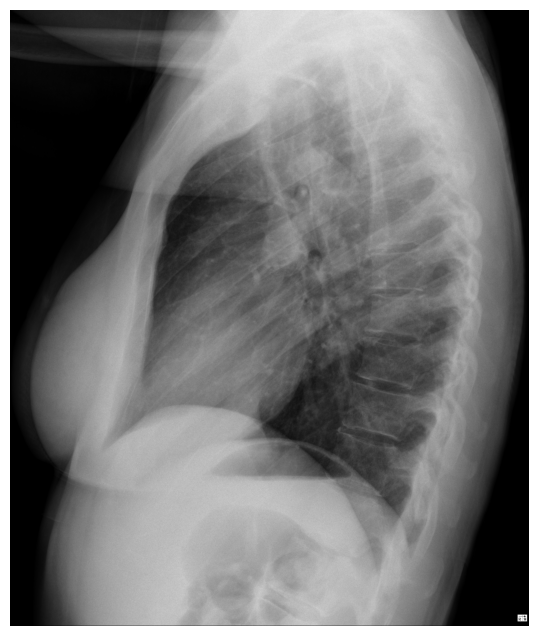

DicomPath: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_5b530ef03c6248902a28a56c4d9c055405224a79/Study_2.25.787805121029830105111315341127/Series_2.25.147112013213159215862131094331/image-2.25.891269911113658121241501361331.dcm
StudyInstanceUID: 2.25.787805121029830105111315341127
SeriesInstanceUID: 2.25.147112013213159215862131094331
PatientID: 5b530ef03c6248902a28a56c4d9c055405224a79
PatientSex: F
PatientAge: 041Y
StudyDate: 2022-10-07
Modality: CR
Manufacturer: 0fa5e7a5d523b25b6d8fd91c3b1d2059
ManufacturerModelName: ac560d1a4308f6dd82b45195f223482f
BodyPartExamined: CHEST
ViewPosition: 


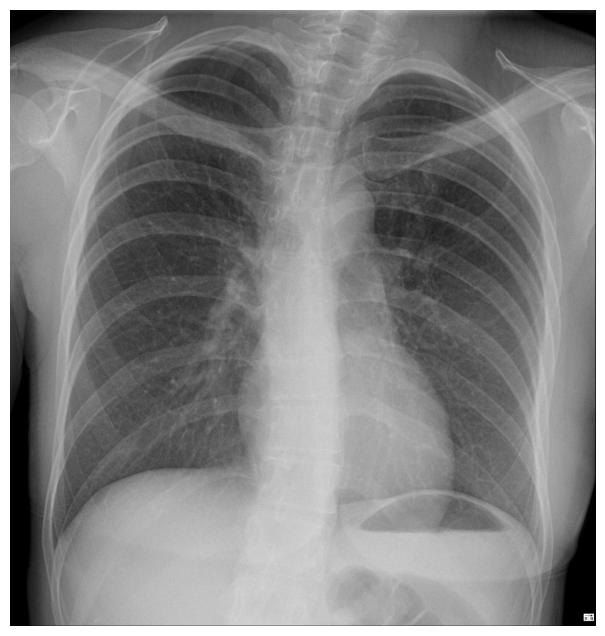


Report:
RADIOGRAFÍA DE PIERNA IZQUIERDA AP - LATERAL.
RADIOGRAFÍA DE TOBILLO IZQUIERDO AP - LATERAL Y OBLICUA CON CARGA.
Esguince.
Densidad ósea conservada.
No hay signos de una lesión ósea traumática ni destructiva en estas proyecciones.
Articulación tibioperonea astragalina congruente, de amplitud normal.
Espacios articulares de la rodilla de amplitud normal y márgenes óseos regulares.
Restantes espacios articulares del retropié visibles de amplitud normal.
No hay signos de derrame articular en receso tibio astragalino anterior ni en el receso
suprapatelar.
La sombra del tendón de Aquiles es de grosor normal y presenta un borde anterior bien definido.
Proliferación ósea por entesopatía degenerativa en el sitio de inserción del tendón de Aquiles en el
calcáneo.
No hay calcificaciones intra ni periarticulares.
Leve aumento de volumen y densidad de las partes blandas que rodean el tobillo.
RADIOGRAFÍA DE DEDO ANULAR DERECHO AP - LATERAL - OBLICUA.
Hallazgos.
Densidad ósea conservada.
N

In [82]:
show_study(patient_id='5b530ef03c6248902a28a56c4d9c055405224a79',
           study_id='2.25.78780512102983010511131534112744907414130105155621',
           dir_path='/mnt/workspace/ucchristus_sample/tmp2')

### Facts extracted from report

**RADIOGRAFÍA DE PIERNA IZQUIERDA AP - LATERAL.**   
**RADIOGRAFÍA DE TOBILLO IZQUIERDO AP - LATERAL Y OBLICUA CON CARGA.**

- A sprain is present.
- Bone density is preserved.
- No signs of traumatic bone injury are observed in these projections.
- No signs of destructive bone injury are observed in these projections.
- The tibioperoneal astragalian joint is congruent.
- The tibioperoneal astragalian joint has normal amplitude.
- The knee joint spaces have normal amplitude.
- The bone margins of the knee are regular.
- The remaining joint spaces of the hindfoot are visible.
- The remaining joint spaces of the hindfoot have normal amplitude.
- No signs of joint effusion are observed in the anterior tibioastragalian recess.
- No signs of joint effusion are observed in the suprapatellar recess.
- The Achilles tendon shadow has normal thickness.
- The Achilles tendon shadow has a well-defined anterior edge.
- Bone proliferation is present at the Achilles tendon insertion site on the calcaneus.
- The bone proliferation is due to degenerative enthesopathy.
- No intra-articular calcifications are observed.
- No periarticular calcifications are observed.
- There is a slight increase in volume of the soft tissues surrounding the ankle.
- There is a slight increase in density of the soft tissues surrounding the ankle.

**RADIOGRAFÍA DE DEDO ANULAR DERECHO AP - LATERAL - OBLICUA.**

- Bone density is preserved.
- No signs of traumatic bone injury are observed.
- No signs of destructive bone injury are observed.
- Joint spaces of normal amplitude are visible.
- Bone margins are regular.
- No intra-articular calcifications are identified.
- No periarticular calcifications are identified.
- There is a slight increase in volume of the soft tissues adjacent to the proximal interphalangeal joint.
- There is a slight increase in density of the soft tissues adjacent to the proximal interphalangeal joint.

**RADIOGRAFÍA DE TÓRAX PA - LATERAL.**

- The diaphragm is well-defined.
- No signs of pleural effusion are observed.
- No signs of pneumothorax are observed.
- Pulmonary volumes are normal.
- No areas of consolidation are identified in the pulmonary parenchyma.
- No masses are identified in the pulmonary parenchyma.
- The cardiac silhouette is of normal size.
- The thoracic aorta is minimally elongated.
- The hilar regions show no alterations.
- The pulmonary vascular pattern shows no alterations.

# Example 8

In [83]:
!ls /mnt/workspace/ucchristus_sample/tmp2/REPORTS/id_8e7c9a78eabc1b2888341124a1441957fded238d/

study-2.25.14891529610311341050410151371041504008615312159121


In [84]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_8e7c9a78eabc1b2888341124a1441957fded238d/', verbose=True, return_files=False)

2022-08-26: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_8e7c9a78eabc1b2888341124a1441957fded238d/Study_2.25.148915296103113410504101513710/Series_2.25.323106133812116312581651013101/image-2.25.158214971313414127414010138145.dcm
2022-09-10: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_8e7c9a78eabc1b2888341124a1441957fded238d/Study_2.25.148915296103113410504101513710/Series_2.25.107311151313232131195412155512/image-2.25.212166514381210312147215825179.dcm


DicomPath: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_8e7c9a78eabc1b2888341124a1441957fded238d/Study_2.25.148915296103113410504101513710/Series_2.25.323106133812116312581651013101/image-2.25.158214971313414127414010138145.dcm
StudyInstanceUID: 2.25.148915296103113410504101513710
SeriesInstanceUID: 2.25.323106133812116312581651013101
PatientID: 8e7c9a78eabc1b2888341124a1441957fded238d
PatientSex: F
PatientAge: 000D
StudyDate: 2022-08-26
Modality: DX
Manufacturer: ef3dfac511f421030d1600e377121512
ManufacturerModelName: 3fabf6d5ea26f78d61042a540bcc964a
BodyPartExamined: CHEST
ViewPosition: AP


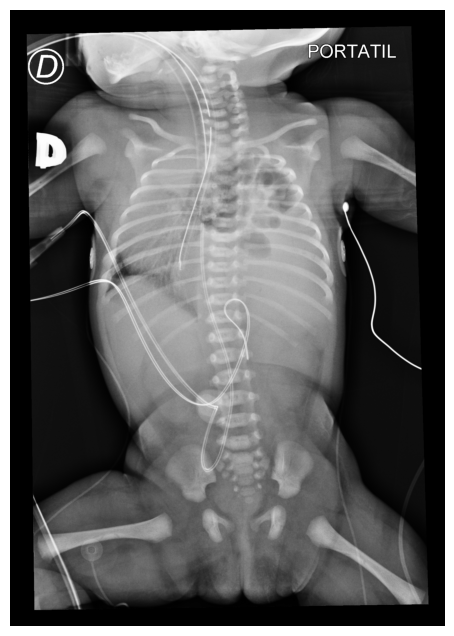

DicomPath: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_8e7c9a78eabc1b2888341124a1441957fded238d/Study_2.25.148915296103113410504101513710/Series_2.25.107311151313232131195412155512/image-2.25.212166514381210312147215825179.dcm
StudyInstanceUID: 2.25.148915296103113410504101513710
SeriesInstanceUID: 2.25.107311151313232131195412155512
PatientID: 8e7c9a78eabc1b2888341124a1441957fded238d
PatientSex: F
PatientAge: 000D
StudyDate: 2022-09-10
Modality: DX
Manufacturer: ef3dfac511f421030d1600e377121512
ManufacturerModelName: 3fabf6d5ea26f78d61042a540bcc964a
BodyPartExamined: CHEST
ViewPosition: XTABLE LATERAL


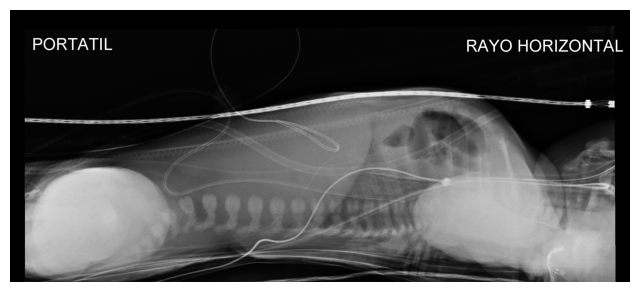


Report:
RX TÓRACO-ABDOMINAL (AP-L CON RAYO HOIZONTAL) PORTÁTIL
HDC
El tórax se encuentra levemente rotado de izquierda a derecha en la radiografía frontal.
Se observa ocupación de la mayor parte del hemitórax izquierdo por el contenido de la hernia, con
abundante meteorismo de las asas ascendidas a la región apical de ese lado.
Significativo desplazamiento del corazón y mediastino hacia la derecha con colapso parcial del
pulmón de ese lado, especial del LS. No se identifica con seguridad expansión del pulmón
neoplásico izquierdo.
El tamaño de la silueta cardíaca no es evaluable.
Tubo endotraqueal con extremo a nivel T2-T3.
Sonda de trayecto esofágico con extremo a la altura de T9, desplazado hacia la derecha.
No se observa meteorismo intestinal en el abdomen.
Catéter arterial umbilical con extremo a nivel de T6. Catéter venoso umbilical acodado en el
conducto venoso.
No se observan calcificaciones intraabdominales patológicas.
Resto del examen sin alteraciones evidentes.



In [85]:
show_study(patient_id='8e7c9a78eabc1b2888341124a1441957fded238d',
           study_id='2.25.14891529610311341050410151371041504008615312159121',
           dir_path='/mnt/workspace/ucchristus_sample/tmp2')

### Facts extracted from report

- The chest is slightly rotated from left to right.
- Most of the left hemithorax is occupied by the contents of the hernia.
- There is abundant meteorism of the loops ascended to the apical region of the left side.
- The heart and mediastinum are significantly displaced to the right.
- There is partial collapse of the lung on the right side.
- The collapse is especially noted in the LS (likely referring to the left superior lobe).
- The expansion of the left neoplastic lung is not identified with certainty.
- The size of the cardiac silhouette is not assessable.
- Endotracheal tube is present with its tip at the level of T2-T3.
- Esophageal trajectory probe is present with its tip at the level of T9.
- The esophageal trajectory probe is displaced to the right.
- No intestinal meteorism is observed in the abdomen.
- Umbilical arterial catheter is present with its tip at the level of T6.
- Umbilical venous catheter is bent in the venous duct.
- No pathological intra-abdominal calcifications are observed.
- The rest of the examination shows no evident alterations.

# Example 9

In [86]:
!ls /mnt/workspace/ucchristus_sample/tmp2/REPORTS/id_1366d2ca78e54bcf86a04c651576276ad24b9e7d/

study-2.25.11111468107407141213110611114101313363117142114421
study-2.25.11122111410915141289851502991501215212526141429411
study-2.25.12211214131513014121217111515710911159213131512210
study-2.25.14085152257121011911121281114121143124813102096413
study-2.25.14186391161014528711147613121249513865145149151115
study-2.25.15015131025154410499121507747213576310313151113961
study-2.25.18194208136101211551514113293412970141383126212141
study-2.25.21051015521415711971039143133701238102271409931166
study-2.25.31086361191111315834602981513114152813121414147541
study-2.25.35141014928134150412131035113103147310713151112102
study-2.25.45104613219410801192151014491272320391101151361413
study-2.25.82094271915131480513115123313912121292111715108261


In [87]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_1366d2ca78e54bcf86a04c651576276ad24b9e7d/', verbose=True, return_files=False)

2018-08-13: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_1366d2ca78e54bcf86a04c651576276ad24b9e7d/Study_2.25.351410149281341504121310351131/Series_2.25.101098111215711115643151574121/image-2.25.149131351292111023073151071213.dcm
2018-08-17: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_1366d2ca78e54bcf86a04c651576276ad24b9e7d/Study_2.25.820942719151314805131151233139/Series_2.25.798531143311112615151334817615/image-2.25.211154815271111778112155611733.dcm
2018-09-01: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_1366d2ca78e54bcf86a04c651576276ad24b9e7d/Study_2.25.820942719151314805131151233139/Series_2.25.798531143311112615151334817615/image-2.25.212147821108913141901118615391.dcm
2018-09-02: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_1366d2ca78e54bcf86a04c651576276ad24b9e7d/Study_2.25.111221114109151412898515029915/Series_2.25.121610212141510130793151303039/image-2.25.135118611141281225810121332561.dcm
2018-11-04: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_1366d2ca78e5

DicomPath: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_1366d2ca78e54bcf86a04c651576276ad24b9e7d/Study_2.25.111114681074071412131106111141/Series_2.25.115236561114721913911613512079/image-2.25.610212126044513948106431414822.dcm
StudyInstanceUID: 2.25.111114681074071412131106111141
SeriesInstanceUID: 2.25.115236561114721913911613512079
PatientID: 1366d2ca78e54bcf86a04c651576276ad24b9e7d
PatientSex: M
PatientAge: 097Y
StudyDate: 2023-07-27
Modality: DX
Manufacturer: ef3dfac511f421030d1600e377121512
ManufacturerModelName: 3fabf6d5ea26f78d61042a540bcc964a
BodyPartExamined: CHEST
ViewPosition: AP


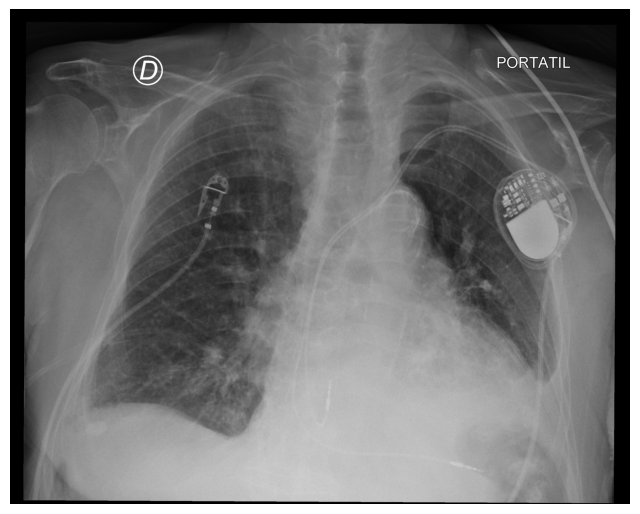


Report:
RADIOGRAFÍA DE TÓRAX AP PORTATIL
Desde ayer presenta episodios de desaturación; en triage 99% SatO2 con apoyo de 2 lts de
oxigeno. Antec de EPOC usuario de O2, Asma, HTA, ICC, Usuario de Marcapasos. Sin alergias
Caja de marcapasos bicameral sobreproyectada a la región pectoral izquierda conectado a
electrodos de trayecto subclavio ipsilateral con extremos distales sobreproyectados a cavidades
cardíacas derechas.
Obliteración del receso costofrénico lateral, de probable carácter adherencial.
Signos sugerente de leve derrame pleural a izquierda. No hay signos categóricos de derrame
pleural a derecha. No hay signos de neumotórax.
Opacidad retrocardíaca basal izquierda en parte determinada por atelectasia. No se observan
focos de relleno alveolar en el parénquima pulmonar expandido.
Leve engrosamiento de los tractos peribroncovasculares en ambos pulmones, lo que sugiere
signos de leve edema intersticial.
Leve aumento de tamaño de la silueta cardíaca para la proyección.
Aorta torác

In [90]:
show_study(patient_id='1366d2ca78e54bcf86a04c651576276ad24b9e7d',
           study_id='2.25.11111468107407141213110611114101313363117142114421',
           dir_path='/mnt/workspace/ucchristus_sample/tmp2')

### Facts extracted from report

- The patient has been experiencing episodes of desaturation since yesterday.
- The patient's oxygen saturation was 99% in triage with the support of 2 liters of oxygen.
- The patient has a history of Chronic Obstructive Pulmonary Disease (COPD).
- The patient uses oxygen therapy.
- The patient has a history of Asthma.
- The patient has a history of Hypertension.
- The patient has a history of Heart Failure.
- The patient is a Pacemaker user.
- A bicameral pacemaker box is superimposed on the left pectoral region.
- The pacemaker is connected to electrodes of the ipsilateral subclavian path.
- The distal ends of the electrodes are superimposed on the right cardiac cavities.
- The lateral costophrenic recess is obliterated.
- The obliteration is likely of an adhesive nature.
- There are signs suggestive of mild pleural effusion on the left.
- There are no categorical signs of pleural effusion on the right.
- There are no signs of pneumothorax.
- There is left basal retrocardiac opacity.
- The opacity is partly determined by atelectasis.
- No alveolar filling foci are observed in the expanded pulmonary parenchyma.
- There is mild thickening of the peribronchovascular tracts in both lungs.
- The thickening suggests signs of mild interstitial edema.
- There is a mild enlargement of the cardiac silhouette for the projection.
- The thoracic aorta is elongated.
- There is calcified atheroma plaque in the arch and descending portion of the thoracic aorta.

# Example 10

In [92]:
!ls /mnt/workspace/ucchristus_sample/tmp2/REPORTS/id_317554204f37a399136f0777810d41bcd14ec124/

study-2.25.14101318941015571111721113157761398912212604310871
study-2.25.79031211341081011127101041211314913665877121134484


In [91]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_317554204f37a399136f0777810d41bcd14ec124/', verbose=True, return_files=False)

2023-08-02: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_317554204f37a399136f0777810d41bcd14ec124/Study_2.25.790312113410810111271010412113/Series_2.25.513337179101339514851511131511/image-2.25.971413116131468494112119878121.dcm
2023-08-09: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_317554204f37a399136f0777810d41bcd14ec124/Study_2.25.141013189410155711117211131577/Series_2.25.141087112513451412913520594411/image-2.25.513435104015112141212484012971.dcm
2023-08-10: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_317554204f37a399136f0777810d41bcd14ec124/Study_2.25.141013189410155711117211131577/Series_2.25.141441471497121353811632121081/image-2.25.166107151812106911365134281181.dcm
2023-08-15: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_317554204f37a399136f0777810d41bcd14ec124/Study_2.25.790312113410810111271010412113/Series_2.25.141115811267914125110810371393/image-2.25.120401249491313531150137101361.dcm


DicomPath: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_317554204f37a399136f0777810d41bcd14ec124/Study_2.25.141013189410155711117211131577/Series_2.25.141087112513451412913520594411/image-2.25.513435104015112141212484012971.dcm
StudyInstanceUID: 2.25.141013189410155711117211131577
SeriesInstanceUID: 2.25.141087112513451412913520594411
PatientID: 317554204f37a399136f0777810d41bcd14ec124
PatientSex: M
PatientAge: 006D
StudyDate: 2023-08-09
Modality: DX
Manufacturer: ef3dfac511f421030d1600e377121512
ManufacturerModelName: 3fabf6d5ea26f78d61042a540bcc964a
BodyPartExamined: CHEST
ViewPosition: AP


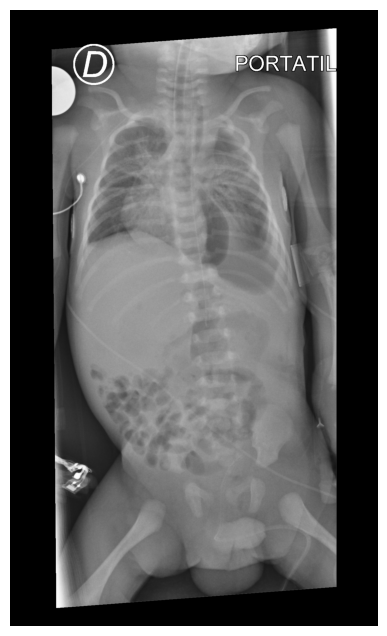

DicomPath: /mnt/workspace/ucchristus_sample/tmp2/DICOMS/id_317554204f37a399136f0777810d41bcd14ec124/Study_2.25.141013189410155711117211131577/Series_2.25.141441471497121353811632121081/image-2.25.166107151812106911365134281181.dcm
StudyInstanceUID: 2.25.141013189410155711117211131577
SeriesInstanceUID: 2.25.141441471497121353811632121081
PatientID: 317554204f37a399136f0777810d41bcd14ec124
PatientSex: M
PatientAge: 006D
StudyDate: 2023-08-10
Modality: DX
Manufacturer: ef3dfac511f421030d1600e377121512
ManufacturerModelName: 3fabf6d5ea26f78d61042a540bcc964a
BodyPartExamined: CHEST
ViewPosition: AP


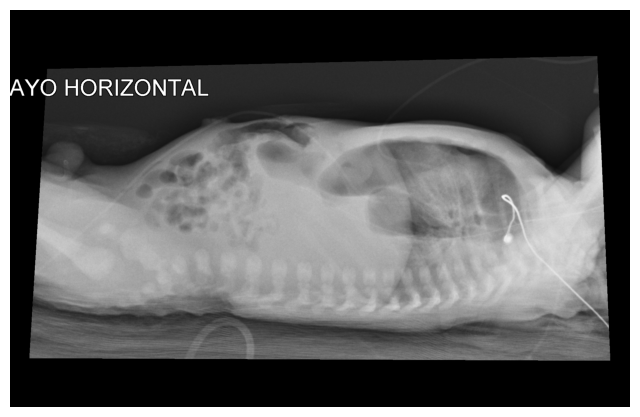


Report:
RADIOGRAFÍA DE TÓRAX (AP - LAT ) PORTÁTIL
6 ddv. HDC. Obstrucción intestinal operada, alrededor de 24 horas atrás.
Con respecto a examen preoperatorio del día de ayer, se observa actualmente meteorismo
intestinal de aspecto normal, sin dilatación patológica de asas ni niveles líquidos en su interior.
Pequeño neumoperitoneo anterior, seguramente postquirúrgico.
Sonda enteral en estómago.
En el tórax, no hay cambios significativos en el hidroneumotórax izquierdo, probablemente con un
componente tabicado posterior, lo que explica la presencia de dos niveles hidroaéreos en el
hemitórax izquierdo.
Tampoco hay cambios en el grado de aireación del pulmón hipoplásico de ese lado, con
opacidades difusas en su interior.
Pulmón derecho mejor aireado, con disminución en las sombras descritas.
Menor grado de desplazamiento de las estructuras mediastino hacia la derecha.
Tubo endotraqueal a la altura de T2.
Sonda enteral en estómago, en la región del epigastrio.
Resto sin cambios.



In [94]:
show_study(patient_id='317554204f37a399136f0777810d41bcd14ec124',
           study_id='2.25.14101318941015571111721113157761398912212604310871',
           dir_path='/mnt/workspace/ucchristus_sample/tmp2')

### Facts extracted from report

- The patient has been hospitalized for 6 days.
- The patient underwent surgery for intestinal obstruction about 24 hours ago.
- The current examination is compared to the preoperative examination from yesterday.
- Normal-looking intestinal meteorism is observed.
- There is no pathological dilation of intestinal loops.
- There are no liquid levels inside the intestinal loops.
- A small anterior pneumoperitoneum is observed.
- The pneumoperitoneum is likely post-surgical.
- An enteral tube is present in the stomach.
- There are no significant changes in the left hydropneumothorax.
- The left hydropneumothorax likely has a posterior septated component.
- There are two hydroaerial levels in the left hemithorax.
- There are no changes in the degree of aeration of the hypoplastic lung on that side.
- There are diffuse opacities within the hypoplastic lung on that side.
- The right lung is better aerated.
- There is a decrease in the described shadows in the right lung.
- There is a lesser degree of displacement of the mediastinal structures to the right.
- An endotracheal tube is present at the level of T2.
- An enteral tube is present in the stomach, in the epigastric region.
- No changes are observed in the rest of the examined areas.

# Example 11

In [95]:
!ls /mnt/workspace/ucchristus_sample/tmp3/REPORTS/id_10ca7e630dfc08113a7a30a73e72f1dc927e0fff/

study-2.25.11913438111048111480344511513215613565611117153631
study-2.25.21141581590909146113157151415013712107091021511010
study-2.25.91313123610441415103142151282121106012814806403051


In [97]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_10ca7e630dfc08113a7a30a73e72f1dc927e0fff/', verbose=True, return_files=False)

2022-11-03: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_10ca7e630dfc08113a7a30a73e72f1dc927e0fff/Study_2.25.119134381110481114803445115132/Series_2.25.411057502412503742363157513111/image-2.25.922141012108111512535121212705.dcm
2023-02-12: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_10ca7e630dfc08113a7a30a73e72f1dc927e0fff/Study_2.25.211415815909091461131571514150/Series_2.25.651104314106613141711751260151/image-2.25.127287141412113152121581051101.dcm
2023-02-23: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_10ca7e630dfc08113a7a30a73e72f1dc927e0fff/Study_2.25.913131236104414151031421512821/Series_2.25.121213131214115105411588144151/image-2.25.555915121452716390215318123139.dcm
2023-02-26: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_10ca7e630dfc08113a7a30a73e72f1dc927e0fff/Study_2.25.913131236104414151031421512821/Series_2.25.681190211961413439129760614766/image-2.25.611826497013510151547144913721.dcm


DicomPath: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_10ca7e630dfc08113a7a30a73e72f1dc927e0fff/Study_2.25.119134381110481114803445115132/Series_2.25.411057502412503742363157513111/image-2.25.922141012108111512535121212705.dcm
StudyInstanceUID: 2.25.119134381110481114803445115132
SeriesInstanceUID: 2.25.411057502412503742363157513111
PatientID: 10ca7e630dfc08113a7a30a73e72f1dc927e0fff
PatientSex: M
PatientAge: 069Y
StudyDate: 2022-11-03
Modality: DX
Manufacturer: ef3dfac511f421030d1600e377121512
ManufacturerModelName: 3fabf6d5ea26f78d61042a540bcc964a
BodyPartExamined: CHEST
ViewPosition: AP


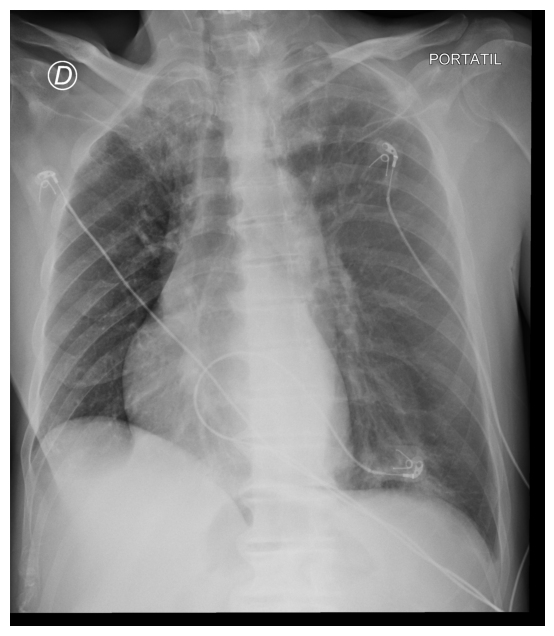


Report:
RADIOGRAFÍA DE TÓRAX AP PORTÁTIL
Sd. Confusional agudo.
No hay derrame pleural ni neumotórax.
Opacidad parenquimatosa de relleno alveolar apical derecha que en retrospectiva correspondía a
cambios cicatriciales pleuroparenquimatosos en radiografía de referencia. Si bien existe rotación
del tórax en el presente estudio, impresiona existir disminución del volumen del hemitórax derecho
manifestado por disminución de la amplitud de los espacios intercostales y ascenso del
hemidiafragma ipsilateral hallazgos que en su conjunto sugieren un foco de condensación apical
derecho con componente atelectásico.
Atelectasia subsegmentaria basal izquierda.
Silueta cardíaca de tamaño dentro de límites normales.
Aorta torácica e hilios pulmonares sin alteraciones.



In [98]:
show_study(patient_id='10ca7e630dfc08113a7a30a73e72f1dc927e0fff',
           study_id='2.25.11913438111048111480344511513215613565611117153631',
           dir_path='/mnt/workspace/ucchristus_sample/tmp3')

### Facts extracted from report

- The patient presents with acute confusional syndrome.
- No pleural effusion is observed.
- No pneumothorax is observed.
- Right apical alveolar filling parenchymal opacity is observed.
- The opacity corresponds to pleuroparenchymal scar changes seen in the reference radiography.
- There is rotation of the thorax in the present study.
- A decrease in the volume of the right hemithorax is observed.
- Decrease in the amplitude of the intercostal spaces is observed.
- Elevation of the ipsilateral hemidiaphragm is observed.
- Findings suggest a focus of right apical consolidation with an atelectatic component.
- Left basal subsegmental atelectasis is observed.
- The cardiac silhouette is within normal size limits.
- No alterations in the thoracic aorta are observed.
- No alterations in the pulmonary hila are observed.

# Example 12

In [99]:
!ls /mnt/workspace/ucchristus_sample/tmp3/REPORTS/id_e4b8ee1fba809a89d39ceedabda55dbe15d7faac/

study-2.25.10921151115613568112134136150799214637773612111012
study-2.25.11088121591967111204148313367121413141001361035911
study-2.25.11100135031377606248134143712131586614310131111781
study-2.25.11231611227122712131212710131113361424151713341312
study-2.25.11310813544158115130101021011153120910146142762111
study-2.25.11414896991412851110131095091115141214314139146240
study-2.25.11451731011311151590614512383614608149641177121281
study-2.25.11821452015121069744151231321051510131401113125140
study-2.25.12101110031259315151121909159852323581214898137121
study-2.25.12131014111103499161415138821554671137111214044156
study-2.25.13490101133129139454336001203113138134510751511136
study-2.25.13813372217151088013174602713141011212500100314145
study-2.25.14701311814358935107431810015015972315947281291152
study-2.25.15101123219414151310177960829412697108121211181978
study-2.25.15141548556101011413315121161414190121115125152578
study-2.25.17100815151112447151012215613109515121131512910131
study-2.

In [100]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_e4b8ee1fba809a89d39ceedabda55dbe15d7faac/', verbose=True, return_files=False)

2018-10-08: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_e4b8ee1fba809a89d39ceedabda55dbe15d7faac/Study_2.25.881561115110151095781515310818/Series_2.25.673128081214111071131011329385/image-2.25.151531413111691102731611106673.dcm
2018-10-09: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_e4b8ee1fba809a89d39ceedabda55dbe15d7faac/Study_2.25.114148969914128511101310950911/Series_2.25.151315552135103406141313810361/image-2.25.610141151212737473511112106111.dcm
2018-10-18: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_e4b8ee1fba809a89d39ceedabda55dbe15d7faac/Study_2.25.109211511156135681121341361507/Series_2.25.534891310661365274129913470151/image-2.25.142146102411510558012156814121.dcm
2018-10-20: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_e4b8ee1fba809a89d39ceedabda55dbe15d7faac/Study_2.25.134901011331291394543360012031/Series_2.25.132497150395921191561111114132/image-2.25.759635119124340115091117787139.dcm
2018-10-28: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_e4b8ee1fba80

### Previous study (2019-07-07)

DicomPath: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_e4b8ee1fba809a89d39ceedabda55dbe15d7faac/Study_2.25.110881215919671112041483133671/Series_2.25.113789146271367102111414113141/image-2.25.914151188211210914451021604241.dcm
StudyInstanceUID: 2.25.110881215919671112041483133671
SeriesInstanceUID: 2.25.113789146271367102111414113141
PatientID: e4b8ee1fba809a89d39ceedabda55dbe15d7faac
PatientSex: F
PatientAge: 036Y
StudyDate: 2019-07-07
Modality: DX
Manufacturer: ef3dfac511f421030d1600e377121512
ManufacturerModelName: 3fabf6d5ea26f78d61042a540bcc964a
BodyPartExamined: CHEST
ViewPosition: AP


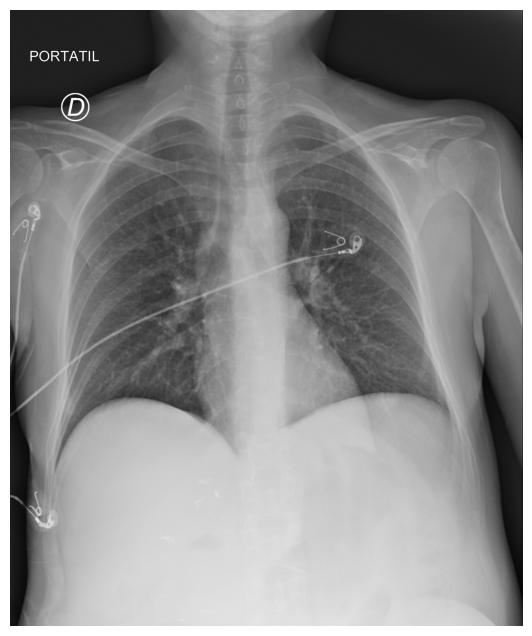


Report:
RADIOGRAFÍA DE TÓRAX PA - LATERAL 
Diafragma bien delimitado. 
No hay signos categóricos de derrame pleural ni neumotórax. 
No hay focos de relleno alveolar en el parénquima pulmonar. 
No hay signos categóricos de edema intersticial. 
Silueta cardíaca de tamaño dentro de límites normales. 
Aorta torácica e hilios pulmonares sin alteraciones categóricas. 
Clips quirúrgicos sobreproyectados al epigastrio. 



In [103]:
show_study(patient_id='e4b8ee1fba809a89d39ceedabda55dbe15d7faac',
           study_id='2.25.11088121591967111204148313367121413141001361035911',
           dir_path='/mnt/workspace/ucchristus_sample/tmp3')

### Current study (2019-07-11)

DicomPath: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_e4b8ee1fba809a89d39ceedabda55dbe15d7faac/Study_2.25.121011100312593151511219091598/Series_2.25.143341412144131411910101423471/image-2.25.821511210712743851567614142810.dcm
StudyInstanceUID: 2.25.121011100312593151511219091598
SeriesInstanceUID: 2.25.143341412144131411910101423471
PatientID: e4b8ee1fba809a89d39ceedabda55dbe15d7faac
PatientSex: F
PatientAge: 036Y
StudyDate: 2019-07-11
Modality: DX
Manufacturer: ef3dfac511f421030d1600e377121512
ManufacturerModelName: 3fabf6d5ea26f78d61042a540bcc964a
BodyPartExamined: CHEST
ViewPosition: AP


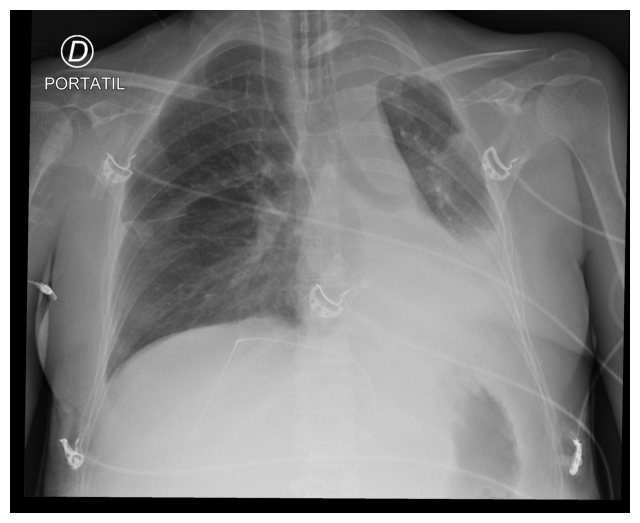


Report:
RADIOGRAFÍA DE TÓRAX AP PORTÁTIL 
Se dispone para comparar de tomografía computada del 11/07/2019 y radiografía del 10/07/2019. 
En comparación con tomografía computada del día de ayer se ha instalado tubo endotraqueal, con 
extremo distal a 3,4 cm de la carina. 
Catéter venoso central yugular derecho con extremo distal en unión atriocava superior, sin 
cambios. 
Leve derrame pleural bilateral que impresiona mayor a izquierda. 
No hay signos categóricos de neumotórax. 
Signos de pérdida de volumen de hemitórax izquierdo con desplazamiento de estructuras 
mediastínicas hacia ipsilateral, asociado a aumento en extensión de foco de condensación que 
impresiona comprometer actualmente lóbulos superior e inferior, compatible con atelectasia. 
Se ha hecho evidente tenue opacidad parenquimatosa en segmentos visibles del pulmón ventilado 
izquierdo, que puede estar en contexto de foco de relleno alveolar.  
Silueta cardíaca no evaluable. 
Clips quirúrgicos y tubo de drenaje con extrem

In [101]:
show_study(patient_id='e4b8ee1fba809a89d39ceedabda55dbe15d7faac',
           study_id='2.25.12101110031259315151121909159852323581214898137121',
           dir_path='/mnt/workspace/ucchristus_sample/tmp3')

### Facts extracted from report

- A computed tomography from 07/11/2019 is available for comparison.
- A radiograph from 07/10/2019 is available for comparison.
- An endotracheal tube has been installed since the computed tomography from yesterday.
- The distal end of the endotracheal tube is at 3.4 cm from the carina.
- Right jugular central venous catheter is present.
- The distal end of the catheter is in the superior atrio-caval junction.
- There are no changes in the position of the right jugular central venous catheter compared to previous studies.
- Mild bilateral pleural effusion is present.
- The pleural effusion appears greater on the left side.
- No signs of pneumothorax are observed.
- Volume loss in the left hemithorax is observed.
- Displacement of mediastinal structures towards the ipsilateral side is observed.
- There is an increase in the extent of a consolidation focus.
- The consolidation focus appears to involve the upper and lower lobes of the left lung.
- The findings are compatible with atelectasis.
- A faint parenchymal opacity is evident in the ventilated left lung.
- The parenchymal opacity may be in the context of an alveolar filling focus.
- The cardiac silhouette is not evaluable.
- Surgical clips are present.
- A drainage tube with the distal end is overprojected onto the right hypochondrium.

# Example 13

In [104]:
!ls /mnt/workspace/ucchristus_sample/tmp3/REPORTS/id_bd36d5adc00bb83c75488bd65493143c7413c756/

study-2.25.10145146842136112102104671451141271006608414153613
study-2.25.11100132714111310113765014144101021132108120141160
study-2.25.11402359115140121551471210438113101211129371312414
study-2.25.11598713111086011098313811025131144615413102148914
study-2.25.12113134996335389144188781114111251341031822109410
study-2.25.12141178891271341561001114010144895613114442139108
study-2.25.12631571512533177793654014706102113491112109111433
study-2.25.12772711999131131380314112110109051510215141311441
study-2.25.13010111121518125104102041412912813211001012838131
study-2.25.13101081230381111137111088136151041010116512125110
study-2.25.13149321331223311311531411013941415474114156147473
study-2.25.14141010411185513911112109813707912112814514611611
study-2.25.15101410827311407111061101361210971218127101587102
study-2.25.15631411513314142553123151311241139142011931106131
study-2.25.1853568143252414612512592263717871466411181411811
study-2.25.20111073582014111272259914124112211581012106011240
study-2.2

In [105]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_bd36d5adc00bb83c75488bd65493143c7413c756/', verbose=True, return_files=False)

2021-06-15: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_bd36d5adc00bb83c75488bd65493143c7413c756/Study_2.25.101451468421361121021046714511/Series_2.25.253710151221310121113150714147/image-2.25.102106451311148153101467120131.dcm
2021-06-16: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_bd36d5adc00bb83c75488bd65493143c7413c756/Study_2.25.758121541369715221210999246813/Series_2.25.677736291351150113116113164110/image-2.25.120313648156135414738304914131.dcm
2021-06-17: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_bd36d5adc00bb83c75488bd65493143c7413c756/Study_2.25.714921014131141015195358646411/Series_2.25.151571133778111196599122112111/image-2.25.172721314413801815414456121561.dcm
2021-06-17: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_bd36d5adc00bb83c75488bd65493143c7413c756/Study_2.25.951411431471521461467147515111/Series_2.25.111318262121553102571311130941/image-2.25.141010032123738414121111853122.dcm
2021-06-21: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_bd36d5adc00b

DicomPath: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_bd36d5adc00bb83c75488bd65493143c7413c756/Study_2.25.714921014131141015195358646411/Series_2.25.151571133778111196599122112111/image-2.25.172721314413801815414456121561.dcm
StudyInstanceUID: 2.25.714921014131141015195358646411
SeriesInstanceUID: 2.25.151571133778111196599122112111
PatientID: bd36d5adc00bb83c75488bd65493143c7413c756
PatientSex: F
PatientAge: 053Y
StudyDate: 2021-06-17
Modality: DX
Manufacturer: ef3dfac511f421030d1600e377121512
ManufacturerModelName: 3fabf6d5ea26f78d61042a540bcc964a
BodyPartExamined: CHEST
ViewPosition: AP


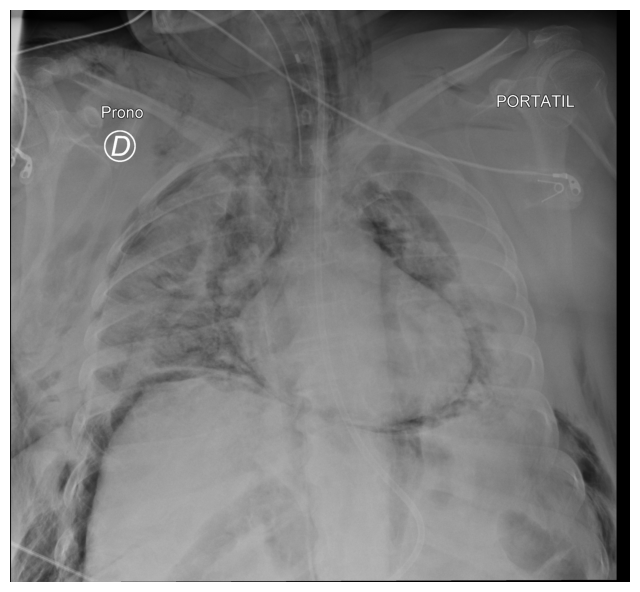


Report:
RADIOGRAFÍA DE TÓRAX PA PORTÁTIL (EN PRONO) 
Respecto a estudio previo se ha reposicionado el tubo endotraqueal, actualmente con extremo 
distal sobreproyectado a 4,4 cm de la carina. 
Catéter venoso central yugular interno derecho y sonda enteral sin cambios de posición. 
Acentuado neumomediastino que se extiende a la región cervical baja, asociado a enfisema 
subcutáneo de la pared toracoabdominal en forma bilateral, actualmente evidenciando imágenes 
radiolúcidas que se extienden hacia la región extrapulmonar en pared torácica lateral derecha, 
probablemente en contexto de enfisema extrapleural versus pequeño componente de neumotórax. 
Hay signos de neumo-retroperitoneo. Existe imagen radiolúcida que se extiende hacia caudal 
rodeando el hemidiafragma/contorno hepático derecho, que sugiere neumoperitoneo libre. 
Se han hecho evidentes signos de un moderado derrame pleural izquierdo (*), de rápida evolución. 
Correlacionar con procedimientos recientes. 
Se sugiere complement

In [106]:
show_study(patient_id='bd36d5adc00bb83c75488bd65493143c7413c756',
           study_id='2.25.71492101413114101519535864641181015510812159152127',
           dir_path='/mnt/workspace/ucchristus_sample/tmp3')

### Facts extracted from report

- The endotracheal tube has been repositioned since the previous study.
- The distal end of the endotracheal tube is projected 4.4 cm from the carina.
- The right internal jugular central venous catheter is unchanged in position.
- The enteral tube is unchanged in position.
- Pronounced pneumomediastinum is present, extending to the lower cervical region.
- Subcutaneous emphysema is present in the bilateral thoracoabdominal wall.
- Radiolucent images are present, extending to the extrapulmonary region in the right lateral thoracic wall.
- The findings suggest extrapleural emphysema or a small pneumothorax component.
- Signs of pneumoretroperitoneum are present.
- A radiolucent image is present, extending caudally surrounding the right hemidiaphragm/hepatic contour.
- The radiolucent image suggests free pneumoperitoneum.
- Signs of a moderate left pleural effusion are evident.
- The left pleural effusion has shown rapid evolution.
- Recent procedures should be correlated with the findings.
- Chest computed tomography is suggested to complement the study.
- The purpose of the CT is to evaluate a possible pneumothorax component and pneumoperitoneum.
- The CT will allow better characterization of the left pleural effusion.
- No signs of right pleural effusion are observed.
- No signs of left pneumothorax are observed.
- Extensive bilateral multifocal alveolar filling opacities are present.
- The opacities are consistent with known viral pneumonia.
- No significant changes are observed in the opacities since the previous study.
- The cardiomediastinal silhouette is unchanged since the previous study.
- No significant variations are observed in the rest of the study.
- A diagnostic alert is made regarding the findings.

# Example 14

In [107]:
!ls /mnt/workspace/ucchristus_sample/tmp3/REPORTS/id_d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977/

study-2.25.11301525586258113651215912611315213121061235376510
study-2.25.2331330811127120556124830942032472571115112915578
study-2.25.61541226137842113134511110056512241114291911841310
study-2.25.815644321426104140231368612114121853415444861015


In [108]:
sort_dicom_by_date('/mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977/', verbose=True, return_files=False)

2018-06-08: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977/Study_2.25.615412261378421131345111100565/Series_2.25.921212667814191001211256848159/image-2.25.989910411513151441314614131014.dcm
2018-06-10: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977/Study_2.25.615412261378421131345111100565/Series_2.25.921212667814191001211256848159/image-2.25.101312813149311614817315131010.dcm
2020-10-16: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977/Study_2.25.233133081112712055612483094203/Series_2.25.151071213125411115118613213131/image-2.25.114151376015010146675831150398.dcm
2020-10-19: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977/Study_2.25.113015255862581136512159126113/Series_2.25.671101215115457121181421581100/image-2.25.114914117451415109564115155111.dcm
2020-10-31: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_d1cf1d2699c6

### Previous study (2020-10-16)

DicomPath: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977/Study_2.25.233133081112712055612483094203/Series_2.25.151071213125411115118613213131/image-2.25.114151376015010146675831150398.dcm
StudyInstanceUID: 2.25.233133081112712055612483094203
SeriesInstanceUID: 2.25.151071213125411115118613213131
PatientID: d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977
PatientSex: M
PatientAge: 073Y
StudyDate: 2020-10-16
Modality: DX
Manufacturer: ef3dfac511f421030d1600e377121512
ManufacturerModelName: 3fabf6d5ea26f78d61042a540bcc964a
BodyPartExamined: CHEST
ViewPosition: AP


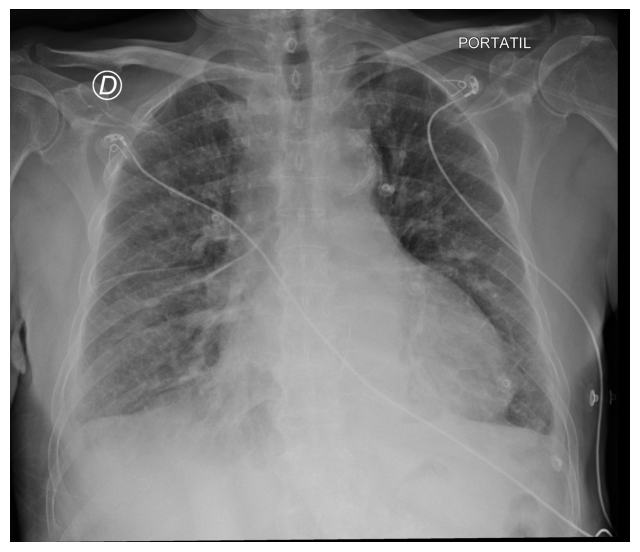


Report:
RADIOGRAFÍA DE TÓRAX AP PORTÁTIL 
Volúmenes pulmonares simétricos. 
Diafragma bien delimitado. 
Impresiona mínimo derrame pleural bilateral. 
No hay signos de neumotórax. 
No se observan focos de condensación en el parénquima pulmonar. 
Opacidad parenquimatosa lineales bibasales, determinadas en parte por atelectasia. 
Prominencia y pérdida de definición hiliar bilateral, asociado a engrosamiento intersticial, 
manifestación de leve edema intersticial. 
Silueta cardíaca de tamaño normal máximo.  
Aorta torácica difusamente elongada con placas de ateroma cálcico en su trayecto.  
Dibujo vascular pulmonar sin alteraciones. 



In [111]:
show_study(patient_id='d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977',
           study_id='2.25.2331330811127120556124830942032472571115112915578',
           dir_path='/mnt/workspace/ucchristus_sample/tmp3')

### Current study (2020-10-19)

DicomPath: /mnt/workspace/ucchristus_sample/tmp3/DICOMS/id_d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977/Study_2.25.113015255862581136512159126113/Series_2.25.671101215115457121181421581100/image-2.25.114914117451415109564115155111.dcm
StudyInstanceUID: 2.25.113015255862581136512159126113
SeriesInstanceUID: 2.25.671101215115457121181421581100
PatientID: d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977
PatientSex: M
PatientAge: 073Y
StudyDate: 2020-10-19
Modality: DX
Manufacturer: ef3dfac511f421030d1600e377121512
ManufacturerModelName: 3fabf6d5ea26f78d61042a540bcc964a
BodyPartExamined: CHEST
ViewPosition: AP


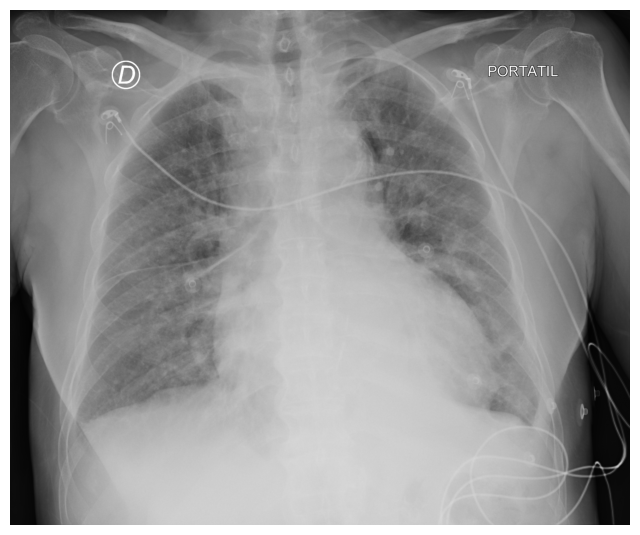


Report:
RADIOGRAFÍA DE TÓRAX PORTÁTIL AP 
En comparación a estudio previo persiste pérdida de definición hiliar bilateral, asociado a 
engrosamiento intersticial y cisural como manifestaciones de moderado edema intersticial. 
Leve derrame pleural bilateral. 
Atelectasias subsegmentarias bibasales. 
No se visualizan signos de neumotórax. 
No se visualizan focos de condensación ni masas en el parénquima pulmonar. 
Moderado aumento de tamaño de la silueta cardíaca. 
Aorta torácica elongada con placas de ateroma que se extienden por su porción descendente. 
Dr. SEBASTIÁN ALEJANDRO QUINTEROS PALOMERA 
Dr. ALVARO HUETE GARÍN 
RMP 




In [109]:
show_study(patient_id='d1cf1d2699c62cdee36ac0e833d3e9f8e92a2977',
           study_id='2.25.11301525586258113651215912611315213121061235376510',
           dir_path='/mnt/workspace/ucchristus_sample/tmp3')

### Facts extracted from report

- Persistent loss of bilateral hilar definition is observed compared to the previous study.
- Interstitial and fissural thickening is associated with moderate interstitial edema.
- Mild bilateral pleural effusion is present.
- Bibasal subsegmental atelectasis is present.
- No signs of pneumothorax are observed.
- No areas of consolidation are observed in the lung parenchyma.
- No masses are observed in the lung parenchyma.
- Moderate enlargement of the cardiac silhouette is observed.
- The thoracic aorta is elongated.
- Atheroma plaques are present in the descending portion of the thoracic aorta.